# Does the University of Maryland need more faculty?
## A data science tutorial by Willy Lang and Seth Rabin

Recently, there's been a lot of hubbub about seats for CS classes.  There were many 400 level classes that filled up almost immediately when registration started. Soon after, there were waitlists of 40-60 students in a lot of sections. Students were worried they wouldn't be able to graduate on time because they couldn't take the classes they needed for their major. This was especially problematic for those in specialized tracks as they couldn't get the classes they needed for their data science or cybersecurity track. Others were being punished for having AP credits or previous experience and getting ahead in their courses. Although they finished lower level classes already, they had fewer overall credits and had to register much later than most. Some worried they would have to take only non-CS classes for a semester just to get enough credits to register earlier next time. It was a big mess.

Petitions were signed, letters were written, complaints were heard. The department ended up opening more seats for almost every class. They even opened an entirely new class. Most people were happy. Or at least, relieved. However, this seemed like a temporary bandaid for a pretty serious issue. Class sizes are really high, especially for the upper level classes. Our student body is still larger than ever, and growing. 

We wanted to see if the CS department really does have a shortage of professors, so we decided to compare our school's departments to other top schools around the country. We're going to start by collecting data on all the schools we want to look at.


## Data munging
### Professors

The first step in our process will be to scour the web in search for the relevant data. We are going to be looking at the top 20 schools from CSRankings.com, as well as their rankings from US News World and Report. Thankfully, csrankings also has their list of professors and their institutions up for open access on their website. We will be using this to get professor counts for each school.

First, we're going to read a csv of professors from various institutions into a pandas dataframe.

In [1]:
import pandas as pd

url1 = "https://raw.githubusercontent.com/emeryberger/CSrankings/gh-pages/csrankings.csv"
professors = pd.read_csv(url1)

But we have to make sure that no professors are included more than once in the data...

### Entity Resolution

Often times, data contains duplicate entries. This can occur because of a number of different reasons. It may be the case that certain entries vary slightly, but actually represent the same entity, so a simple single value check will not always catch all duplicates. As such, it is important to be thorough by checking all attributes, and coming up with a good metric for determining whether entities are the same.

That said, let's examine our data to see if there are any duplicates.

In [2]:
print(len(professors))  # just doing a quick sanity check to make sure the Professors are unique
print(len(professors["name"].unique()))  # by checking if number of unique names is the same as number of records

12547
12547


But wait... it could be the case that some names are similar but not the same. Let's check that theory.

In [3]:
print(len(professors[professors["scholarid"] != 'NOSCHOLARPAGE']["scholarid"]))
print(len(professors[professors["scholarid"] != 'NOSCHOLARPAGE']["scholarid"].unique()))

10003
8458


In [4]:
professors.head(30)

,name,affiliation,homepage,scholarid
0,A. Aldo Faisal,Imperial College London,https://www.imperial.ac.uk/people/a.faisal,WjHjbrwAAAAJ
1,A. Antony Franklin,IIT Hyderabad,http://newslab.iith.ac.in/AntonyFranklin/,LVfqLuoAAAAJ
2,A. C. W. Finkelstein,University College London,http://www0.cs.ucl.ac.uk/staff/a.finkelstein/,n8xuCVkAAAAJ
3,A. D. Fekete,University of Sydney,https://sydney.edu.au/engineering/it/~fekete/,Hs9cVRgAAAAJ
4,A. E. Eiben,VU Amsterdam,http://www.cs.vu.nl/~gusz/,NMuDAe0AAAAJ
5,A. J. Field,Imperial College London,http://www.imperial.ac.uk/people/t.field,rn3Lg2wAAAAJ
6,A. J. Jansen,CWI,https://www.cwi.nl/people/360,qHiBTg0AAAAJ
7,A. J. Kfoury,Boston University,http://www.cs.bu.edu/~kfoury/,VpdYemsAAAAJ
8,A. Jefferson Offutt,George Mason University,http://cs.gmu.edu/~offutt/,NOSCHOLARPAGE
9,A. John Power,University of Bath,http://www.bath.ac.uk/comp-sci/contacts/academ...,mCvZPDn8heUC


As you can see, it turns out there are quite a few duplicates. Fortunately, there is a unique identifier for each scholar that we can use in our entity resolution. Unfortunately, many of these ids are missing, so we will have to resolve these entities in some other way. Let's start with the easy part of removing duplicates that we know exist based on scholarid. If you look at entries 22 and 23, you can see that A. W. Roscoe shows up twice in this data.

For this purpose, we can use the drop_duplicates pandas function. We don't want to drop any of the NOSCHOLARPAGE entries, so we are going to put those aside for now and merge later.

In [5]:
no_schol_page_profs = professors[professors["scholarid"] == "NOSCHOLARPAGE"] 
schol_page_profs = professors[professors["scholarid"] != "NOSCHOLARPAGE"]
unique_professors1 = schol_page_profs.drop_duplicates(['scholarid'])

unique_professors1.head(30)

,name,affiliation,homepage,scholarid
0,A. Aldo Faisal,Imperial College London,https://www.imperial.ac.uk/people/a.faisal,WjHjbrwAAAAJ
1,A. Antony Franklin,IIT Hyderabad,http://newslab.iith.ac.in/AntonyFranklin/,LVfqLuoAAAAJ
2,A. C. W. Finkelstein,University College London,http://www0.cs.ucl.ac.uk/staff/a.finkelstein/,n8xuCVkAAAAJ
3,A. D. Fekete,University of Sydney,https://sydney.edu.au/engineering/it/~fekete/,Hs9cVRgAAAAJ
4,A. E. Eiben,VU Amsterdam,http://www.cs.vu.nl/~gusz/,NMuDAe0AAAAJ
5,A. J. Field,Imperial College London,http://www.imperial.ac.uk/people/t.field,rn3Lg2wAAAAJ
6,A. J. Jansen,CWI,https://www.cwi.nl/people/360,qHiBTg0AAAAJ
7,A. J. Kfoury,Boston University,http://www.cs.bu.edu/~kfoury/,VpdYemsAAAAJ
9,A. John Power,University of Bath,http://www.bath.ac.uk/comp-sci/contacts/academ...,mCvZPDn8heUC
15,A. Rau-Chaplin,Dalhousie University,https://www.cs.dal.ca/~arc/,-PvfVhgAAAAJ


Note that A. W. Roscoe no longer shows up twice in the data. No lets check again to make sure that the number of unique scholarids is equal to the number of entries.

In [6]:
print(len(unique_professors1["scholarid"]))
print(len(unique_professors1["scholarid"].unique()))

8458
8458


This matches our value for unique scholarids seen above, and seems to have been successful. Now let's look throught the NOSCHOLARPAGE professors and figure out if we can remove the duplicates effectively.

In [7]:
no_schol_page_profs.head(30)

,name,affiliation,homepage,scholarid
8,A. Jefferson Offutt,George Mason University,http://cs.gmu.edu/~offutt/,NOSCHOLARPAGE
10,A. M. A. Hemmatyar,Sharif University of Technology,http://ce.sharif.edu/faculty/ali-hemmatyar,NOSCHOLARPAGE
11,A. Neil Arnason,University of Manitoba,http://www.cs.umanitoba.ca/~arnason/,NOSCHOLARPAGE
12,A. P. Wim Böhm,Colorado State University,http://www.cs.colostate.edu/~bohm/,NOSCHOLARPAGE
13,A. Prasad Sistla,University of Illinois at Chicago,https://www.cs.uic.edu/Sistla/,NOSCHOLARPAGE
14,A. Prasad Vinod,Nanyang Technological University,http://www.ntu.edu.sg/home/asvinod/,NOSCHOLARPAGE
16,A. Robert Calderbank,Duke University,https://ece.duke.edu/faculty/robert-calderbank/,NOSCHOLARPAGE
18,A. T. Chamillard,Univ. of Colorado Colorado Springs,http://www.uccs.edu/cs/about/faculty/tim-chami...,NOSCHOLARPAGE
27,Aaram Yun,UNIST,http://aaramyun.unist.ac.kr,NOSCHOLARPAGE
34,Aaron J. Elmore,University of Chicago,http://people.cs.uchicago.edu/~aelmore/,NOSCHOLARPAGE


Abdelhakim Hafid shows up twice here, as you can see in entries 51 and 52. It seems that another useful metric to go by is the website. Surely, if the data is correct, any two professors wth the exact same homepage will be the same professor. Let's use drop_duplicates once again. Note that there could be duplicate professors who have NOSCHALARPAGE for one entry, but have their id present in another. Because of this, we should put the two frames back together, then drop duplicates based on homepage.

In [8]:
dfs = [unique_professors1, no_schol_page_profs]
unique_professors2 = pd.concat(dfs)

In [9]:
professors = unique_professors2.drop_duplicates(['homepage']).copy()
professors.head(30)

,name,affiliation,homepage,scholarid
0,A. Aldo Faisal,Imperial College London,https://www.imperial.ac.uk/people/a.faisal,WjHjbrwAAAAJ
1,A. Antony Franklin,IIT Hyderabad,http://newslab.iith.ac.in/AntonyFranklin/,LVfqLuoAAAAJ
2,A. C. W. Finkelstein,University College London,http://www0.cs.ucl.ac.uk/staff/a.finkelstein/,n8xuCVkAAAAJ
3,A. D. Fekete,University of Sydney,https://sydney.edu.au/engineering/it/~fekete/,Hs9cVRgAAAAJ
4,A. E. Eiben,VU Amsterdam,http://www.cs.vu.nl/~gusz/,NMuDAe0AAAAJ
5,A. J. Field,Imperial College London,http://www.imperial.ac.uk/people/t.field,rn3Lg2wAAAAJ
6,A. J. Jansen,CWI,https://www.cwi.nl/people/360,qHiBTg0AAAAJ
7,A. J. Kfoury,Boston University,http://www.cs.bu.edu/~kfoury/,VpdYemsAAAAJ
9,A. John Power,University of Bath,http://www.bath.ac.uk/comp-sci/contacts/academ...,mCvZPDn8heUC
15,A. Rau-Chaplin,Dalhousie University,https://www.cs.dal.ca/~arc/,-PvfVhgAAAAJ


In [10]:
print(len(professors["homepage"]))
print(len(professors["homepage"].unique()))

10561
10561


Now I think we can say with relative confidence that there is not a significant number of duplicates in our data. That's great, because it means we can move on to counting the number of facuty for each school.

### Faculty count and rank for each of the top 20 schools

It turned out that, considering that csrankings.com is dynamically generated, it is actually easier to just copy and paste the data into a .csv file. So... that's what we're going to do. We are looking at the data from 2007-2017 from csrankings.org.

In [11]:
top_20 = pd.read_csv("top.csv", delimiter="\t")
top_20

,Rank,Institution,Count,Faculty
0,1,► Carnegie Mellon University ◕,18.1,150
1,2,► Massachusetts Institute of Technology ◕,12.3,80
2,3,► Stanford University ◕,10.9,54
3,3,► University of California - Berkeley ◕,10.9,81
4,5,► University of Illinois at Urbana-Champaign ◕,10.0,85
5,6,► Cornell University ◕,8.8,67
6,7,► University of Michigan ◕,8.5,63
7,8,► University of Washington ◕,8.3,56
8,9,► University of California - San Diego ◕,6.9,53
9,10,► Georgia Institute of Technology ◕,6.8,74


As you can see, we have some ugly icons, as well as some extra spaces, which are useless to us. So let's get rid of those really quickly.

In [12]:
list(top_20["Institution  "])

['► Carnegie Mellon University ◕',
 '► Massachusetts Institute of Technology ◕',
 '► Stanford University ◕',
 '► University of California - Berkeley ◕',
 '► University of Illinois at Urbana-Champaign ◕',
 '► Cornell University ◕',
 '► University of Michigan ◕',
 '► University of Washington ◕',
 '► University of California - San Diego ◕',
 '► Georgia Institute of Technology ◕',
 '► Columbia University ◕',
 '► University of Wisconsin - Madison ◕',
 '► University of Pennsylvania ◕',
 '► University of Southern California ◕',
 '► Princeton University ◕',
 '► University of Texas at Austin ◕',
 '► University of Maryland - College Park ◕',
 '► University of California - Los Angeles ◕',
 '► Northeastern University ◕',
 '► Purdue University ◕']

In [13]:
# "Institution" without the whitespace wasn't working when I tried to access the column,
# so I checked to see what the actual column name is
top_20.columns[1] 

'Institution  '

In [14]:
# renaming column to get rid of whitespace in column name
top_20.rename(columns={"Institution  ":"Institution"}, inplace=True)  
# removing the icons and extra whitespace
top_20["Institution"] = top_20["Institution"].apply(lambda x : x[2:-2])  
top_20.head()

,Rank,Institution,Count,Faculty
0,1,Carnegie Mellon University,18.1,150
1,2,Massachusetts Institute of Technology,12.3,80
2,3,Stanford University,10.9,54
3,3,University of California - Berkeley,10.9,81
4,5,University of Illinois at Urbana-Champaign,10.0,85


In [15]:
top_20_institutions = list(top_20['Institution'])
# creating a dataframe by grouping the professors by their affliations and counting the number at each institution
grouped = professors[professors["affiliation"].isin(top_20_institutions)].groupby("affiliation").count()
grouped

,name,homepage,scholarid
affiliation,,,
Carnegie Mellon University,169,169,169
Columbia University,49,49,49
Cornell University,74,74,74
Georgia Institute of Technology,92,92,92
Massachusetts Institute of Technology,109,109,109
Northeastern University,65,65,65
Princeton University,56,56,56
Purdue University,66,66,66
Stanford University,57,57,57


It looks like we're missing Urbana-Champaign. Let's investigate to see what's going on.

In [16]:
# looking for rows where the affiliation contains the string "Urbana"
professors.loc[professors["affiliation"].str.contains("Urbana")].head(10)

,name,affiliation,homepage,scholarid
109,Adam M. Bates,Univ. of Illinois at Urbana-Champaign,http://adambates.org/,IIKFMKoAAAAJ
127,Aditya G. Parameswaran,Univ. of Illinois at Urbana-Champaign,https://cs.illinois.edu/directory/profile/adit...,VeB3UbcAAAAJ
344,Alex Kirlik,Univ. of Illinois at Urbana-Champaign,https://cs.illinois.edu/directory/profile/kirlik/,ZS-2t_AAAAAJ
369,Alexander G. Schwing,Univ. of Illinois at Urbana-Champaign,http://www.alexander-schwing.de/,3B2c31wAAAAJ
398,Alexandra Kolla,Univ. of Illinois at Urbana-Champaign,http://akolla.cs.illinois.edu/,wOb0lqUAAAAJ
689,Andreas Klöckner,Univ. of Illinois at Urbana-Champaign,https://mathema.tician.de/aboutme/,n5dYy5sAAAAJ
741,Andrew Miller,Univ. of Illinois at Urbana-Champaign,http://soc1024.ece.illinois.edu/,KWqO1CgAAAAJ
830,Anil N. Hirani,Univ. of Illinois at Urbana-Champaign,http://www.math.uiuc.edu/~hirani/,2FlUClkAAAAJ
1336,Bertram Ludäscher,Univ. of Illinois at Urbana-Champaign,https://ischool.illinois.edu/people/faculty/lu...,nYx9xasAAAAJ
1376,Bill Gropp,Univ. of Illinois at Urbana-Champaign,http://wgropp.cs.illinois.edu/,vB96fX8AAAAJ


Ah, it just uses a different name. Let's fix it and rerun the code above so we can get the professor counts for Urbana-Champaign. We'll change the name in the professors dataframe just to make life easier when we do joins later on.

In [17]:
professors.replace(to_replace="Univ. of Illinois at Urbana-Champaign", 
                   value="University of Illinois at Urbana-Champaign", inplace=True)
grouped = professors[professors["affiliation"].isin(top_20_institutions)].groupby(
    "affiliation").count()
grouped

,name,homepage,scholarid
affiliation,,,
Carnegie Mellon University,169,169,169
Columbia University,49,49,49
Cornell University,74,74,74
Georgia Institute of Technology,92,92,92
Massachusetts Institute of Technology,109,109,109
Northeastern University,65,65,65
Princeton University,56,56,56
Purdue University,66,66,66
Stanford University,57,57,57


Now we're going to grab the rankings from US News, since they are one of the most popular rankings.

In [18]:
import requests
from bs4 import BeautifulSoup as bs

url_10 = requests.get('https://www.usnews.com/education/best-global-universities/search?region=&country=united-states&subject=computer-science&name=')
soup_10 = bs(url_10.content)
soup_10

/home/krixly/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/krixly/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


<html><head>
<title>Access Denied</title>
</head><body>
<h1>Access Denied</h1>
 
You don't have permission to access "http://www.usnews.com/education/best-global-universities/search?" on this server.<p>
Reference #18.17111cb8.1513451826.5ca61809
</p></body>
</html>

As you can see, usnews doesn't want us to scrape their data. We confirmed this by checking https://www.usnews.com/robots.txt, which shows the websites protocol for scraping allowance. If you want to learn more about robots.txt, you can check this link: http://www.robotstxt.org/robotstxt.html


So, because we couldn't scrape the site, we laboriously entered twenty values into one of the csv files we read in below.
## Student populations
### Data Collection
It was actually pretty difficult to find some of the schools' CS undergraduate populations. Not all of the data was on the web, and some of it was outdated, so instead of scraping data off websites, we just searched and asked departments for their population sizes. We compiled a csv which we will link to and read in from. The CSV contains our sources as well, if you want to reproduce our results.

In [19]:
pops = pd.read_csv("undergraduate_populations_top_20.csv")
pops

,Institution,Number of Undergraduates,Source,Notes,Date
0,Massachusetts Institute of Technology,1348,http://web.mit.edu/registrar/stats/yrpts/index...,NaN,Fall 2017
1,University of Washington,819,https://studentdata.washington.edu/quick-stats/,NaN,Fall 2017
2,University of Maryland - College Park,3109,https://public.tableau.com/shared/RJ346YP5Z?:d...,NaN,Fall 2017
3,Stanford University,663,https://registrar.stanford.edu/everyone/enroll...,NaN,Spring 2017
4,University of California - Berkeley,2857,Private correspondence,NaN,Fall 2017
5,University of Illinois at Urbana-Champaign,1787,https://cs.illinois.edu/about-us/statistics,NaN,Fall 2017
6,Georgia Institute of Technology,2110,http://www.irp.gatech.edu/enrollment,NaN,Fall 2017
7,Northeastern University,1491,Private correspondence,Recieved an email to n.bekerian@northeastern.e...,Fall 2017
8,Cornell University,473,https://www.engineering.cornell.edu/resources/...,NaN,Fall 2017
9,University of Michigan,1039,https://www.eecs.umich.edu/eecs/undergraduate/...,NaN,Fall 2017


Our data is split up into a bunch of different dataframes. We want to merge them into one useful dataframe for data analysis.

In [20]:
pops = pops[["Institution", "Number of Undergraduates"]]
# joining with faculty count dataframe on institution name
top_20 = top_20.join(grouped, on="Institution") 
# joining with undergrad population dataframe on institution name
top_20 = top_20.merge(pops, on="Institution")  
# both of these operations added the rows from the grouped and pops dataframes which matched up with the
# institution name in the top_20 dataframe
top_20 = top_20[["Rank  ", "Institution", "name", "Number of Undergraduates"]]
top_20.rename(columns={"Rank  ":"csankings_rank", "name":"faculty_count", "Institution":"institution",
               "Number of Undergraduates":"undergraduate_pop"}, inplace=True)
top_20

,csankings_rank,institution,faculty_count,undergraduate_pop
0,1,Carnegie Mellon University,169,719
1,2,Massachusetts Institute of Technology,109,1348
2,3,Stanford University,57,663
3,3,University of California - Berkeley,106,2857
4,5,University of Illinois at Urbana-Champaign,99,1787
5,6,Cornell University,74,473
6,7,University of Michigan,70,1039
7,8,University of Washington,59,819
8,9,University of California - San Diego,67,1961
9,10,Georgia Institute of Technology,92,2110


## Data Exploration and Analysis

Now that we have our data all nice a neatly arranged, we can begin analyzing and exploring it to try to find patterns. The majority of our plots will be created using Seaborn, which is a nifty library built on top of matplotlib that makes ploting very easy.

### Comparing the number of students to the number of faculty

The main problem with having too many students, is that there must be a proportionately reasonable number of professors to teach them! Because of this, it's useful to look at the student to factulty and faculty to student ratios to see how UMD matches up with other top 20 schools. The first plot we are going to use is seaborn's regplot. This is a scatter plot which convenienty fits a linear regression line to the data and displays it.

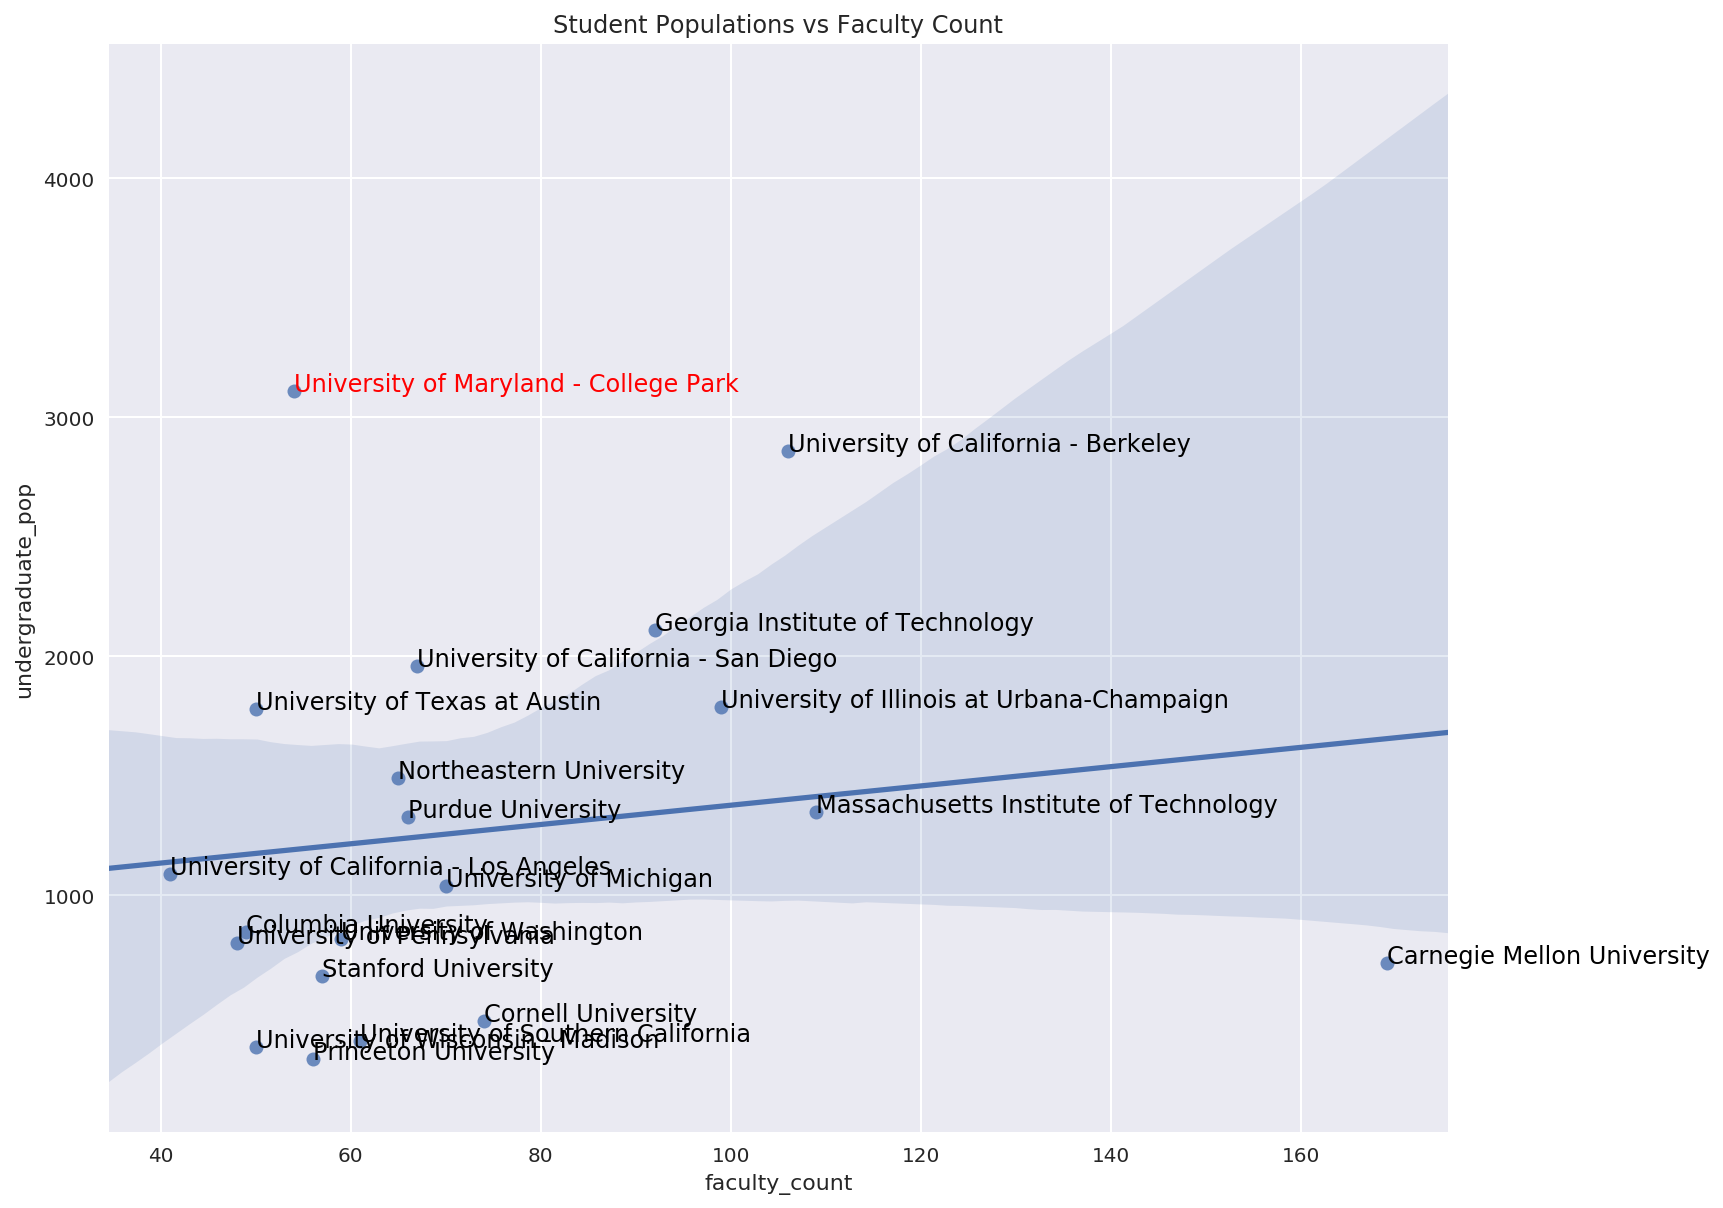

In [21]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# you can add these lines to your jupyter notebook if you don't want to use plt.show()
# everytime you want to display a plot
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# adjusting some plot display settings
matplotlib.rcParams['figure.figsize'] = [12, 10]
sns.set(color_codes=True)

def regplot_top20(df, x, y, title):
    """
    Takes in a dataframe, the name of two columns in the dataframe, and a title
    and creates a sns regplot with labels based on institution.
    """
    fig, ax = plt.subplots()  # exposing the fig and ax here so ax can be used to label
    fig = sns.regplot(df[x], df[y], dropna=True)
    plt.title(title)
    # labeling every point and highlighting UMD
    for i, txt in enumerate(df['institution']):
        if "College Park" in txt:
            c = "red"
        else:
            c = "black"
        ax.annotate(txt, (df[x][i],df[y][i]), color=c)

# plotting student populations vs faculty count
regplot_top20(top_20, "faculty_count", "undergraduate_pop", "Student Populations vs Faculty Count")

Two pretty clear outliers here: University of Maryland- College Park and Carnegie Mellon. Berkeley looks like it's a above trend too. Let's see all the student to faculty ratios, maybe that will help us get a better idea of the situation. To plot this information, we are going to use seaborn's barplot and add a line for the mean ratio.

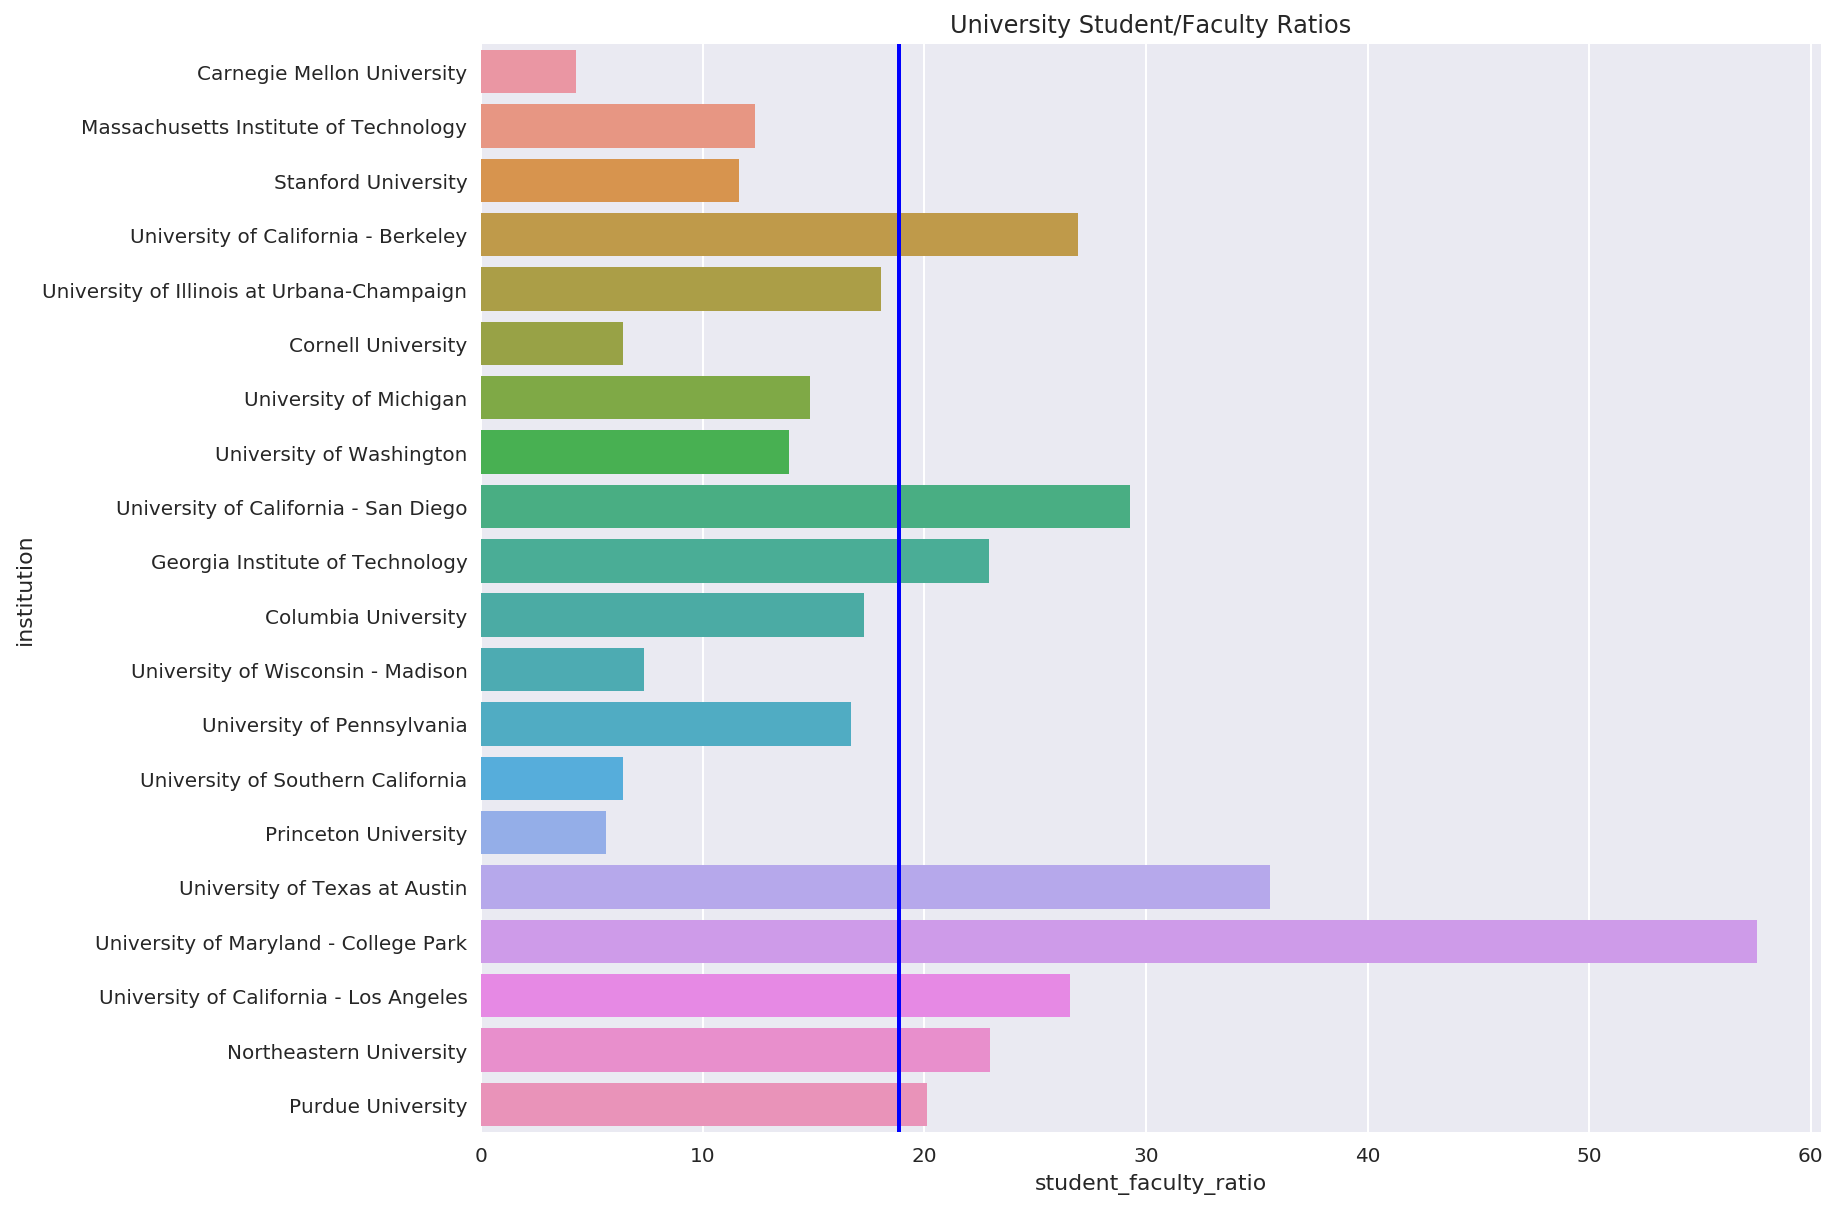

In [22]:
# calculating student/faculty ratio
top_20["student_faculty_ratio"] = top_20["undergraduate_pop"]/top_20["faculty_count"]

fig, ax = plt.subplots()
plt.title("University Student/Faculty Ratios")
fig = sns.barplot(y=top_20["institution"], x=top_20["student_faculty_ratio"])
# adding a verticle line for the mean ratio
ax.axvline(top_20["student_faculty_ratio"].mean(), color="blue", linewidth=2)

It looks like some other schools have pretty close student/faculty ratios on the lower end. UMD looks to be almost triple the average! It also looks like the highest rank ones (remember, the schools are already sorted by their csranking rank) also happen to have lower student/faculty ratios, while the lower 5 are all above the mean.

We know our student population data can be a bit iffy. Some of it was from a semester back because schools didn't provide newer data. Schools are also known to have some policies which will distort major count, like not letting people declare their majors until spring semester or their sophomore year. 

Because of this, we're going to make the (probably massive) overestimation that every school besides UMD doesn't report their freshmen CS population correctly, and they actually have 1.5 times as many total students as they say.

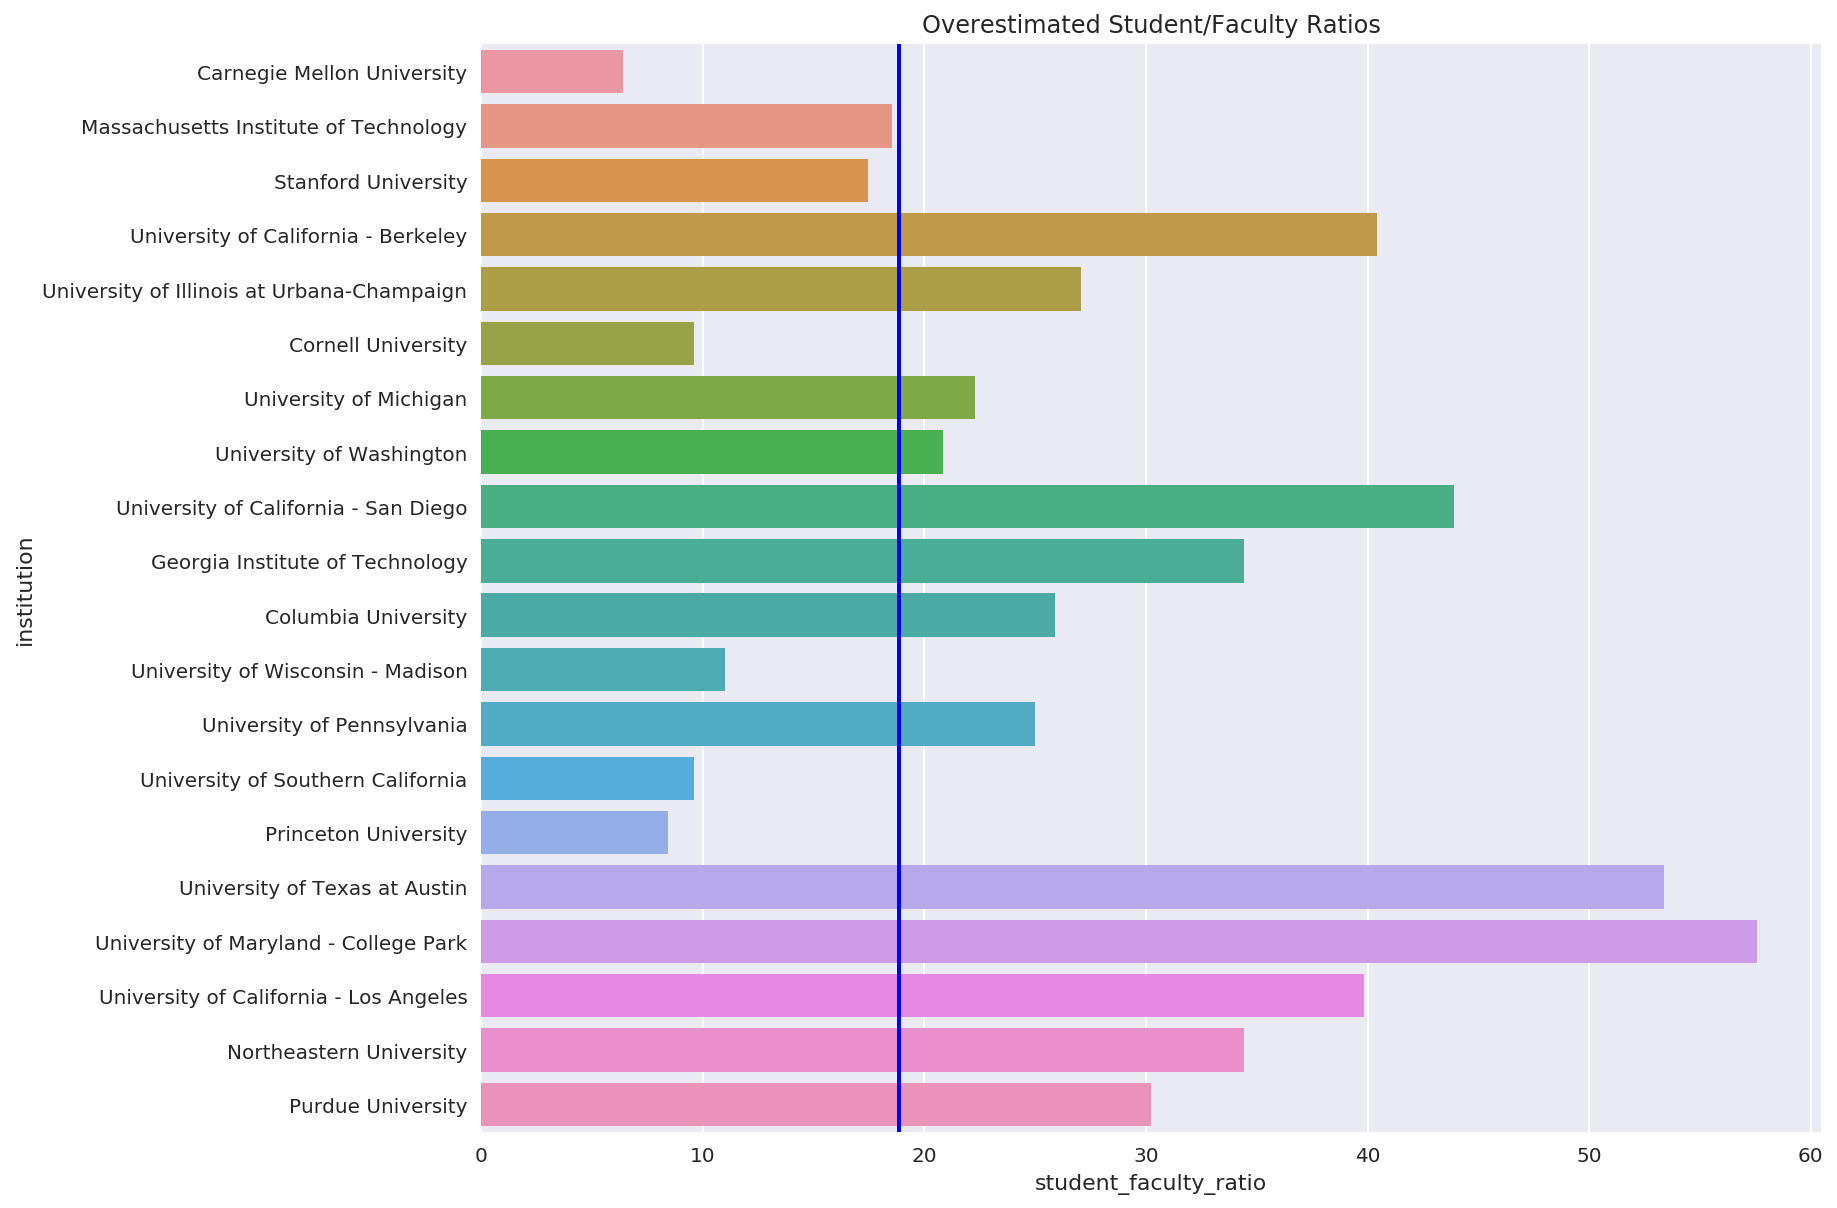

In [23]:
top_20_freshmen = top_20.copy()
# multiplying the population counts by 1.5
top_20_freshmen["new_count"] = top_20_freshmen["undergraduate_pop"]*1.5
# replacing UMD's new count with the old count
top_20_freshmen["new_count"].replace(to_replace=4663.5, value = 3109, inplace=True)
# calculating student/faculty ratio
top_20_freshmen["student_faculty_ratio"] = top_20_freshmen["new_count"]/top_20_freshmen["faculty_count"]
fig, ax = plt.subplots()
plt.title("Overestimated Student/Faculty Ratios")
fig = sns.barplot(y=top_20_freshmen["institution"], x=top_20_freshmen["student_faculty_ratio"])
# adding a verticle line for the mean ratio
ax.axvline(top_20["student_faculty_ratio"].mean(), color="blue", linewidth=2)

Well, it looks like UMD is still the highest, even with this massive overestimation for the other schools. UMD is still almost triple the average! Let's show the scatter plot with the overestimated data so we can how much of an outlier we still are.

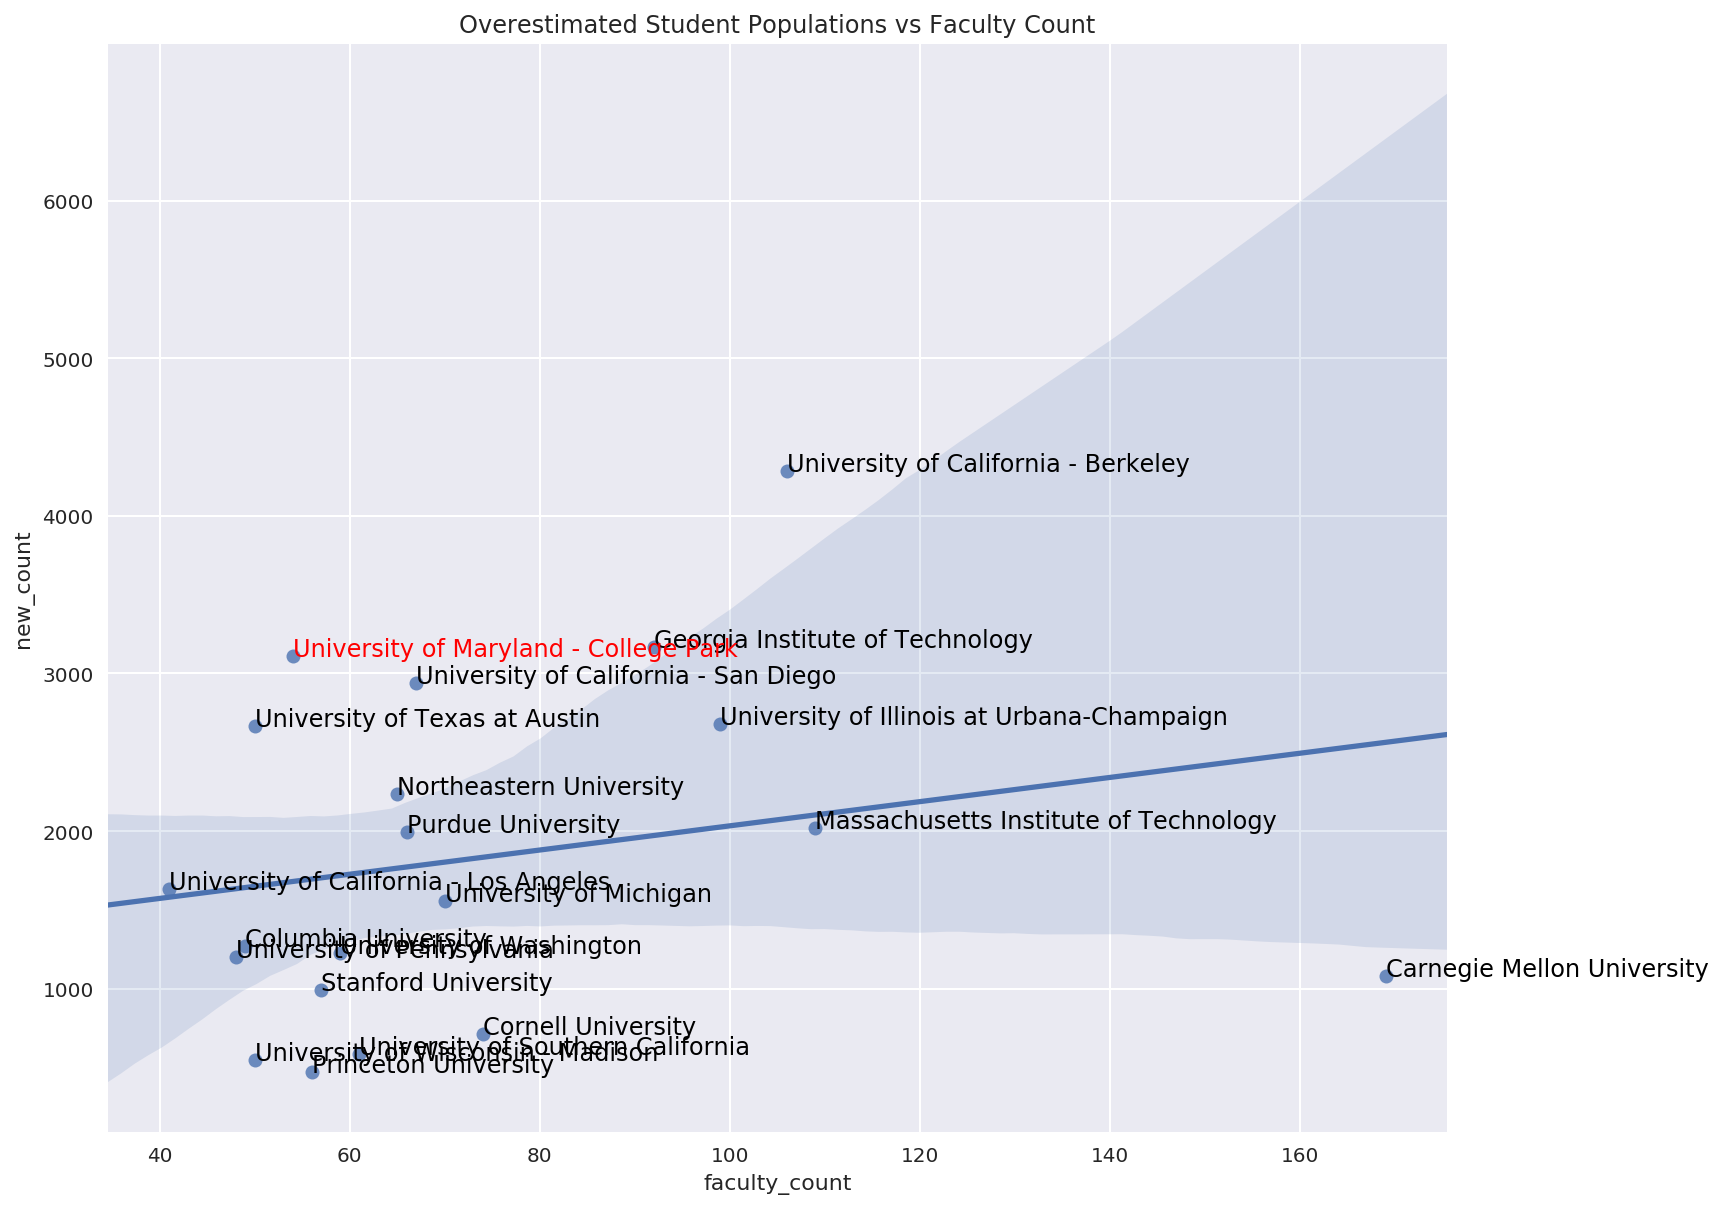

In [24]:
# plotting faculty count vs undergraduate population
regplot_top20(top_20_freshmen, "faculty_count", "new_count", "Overestimated Student Populations vs Faculty Count")

UMD is a lot less of an outlier now! But that's only with an overestimate for every other school's CS population besides ours. So not exactly a plus.

Seeing how high UMD's student/faculty ratio is, it would be interesting to see if students are at least getting a good bang for their buck when it comes to faculty attention. To do this, we need to first get tuition data for all of the schools.

### Obtaining School Tuition Data
This data is readily available on every universities' website. We simply googled each of the top 20 schools. We could have also obtained the data from data.gov or some other data collection site, but this method ensured accuracy of data, up-to-date-ness, and allowed us to find both in-state and out-of-state tuitions. Sometimes brute force is best. We also shoved the usnews rankings into this csv, as we noted above.

In [25]:
tuitions = pd.read_csv('undergraduate_tuitions_top_20.csv')
tuitions

,Institution,usnews_rank,Private/Public,Resident Tuition,Non-Resident Tuition,Source,Notes,Date
0,Massachusetts Institute of Technology,4.0,private,48452.0,48452.0,http://web.mit.edu/facts/tuition.html,NaN,Fall 2016
1,University of Washington,56.0,public,16272.0,28320.0,http://www.washington.edu/financialaid/getting...,NaN,Fall 2017
2,University of Maryland - College Park,42.0,public,10180.0,32044.0,https://www.admissions.umd.edu/finance/costs,NaN,Fall 2017
3,Stanford University,6.0,private,48987.0,48987.0,https://registrar.stanford.edu/everyone/enroll...,NaN,Fall 2016
4,University of California - Berkeley,8.0,public,14068.0,42082.0,http://financialaid.berkeley.edu/cost-attendance,NaN,Fall 2017
5,University of Illinois at Urbana-Champaign,46.0,public,18370.0,34490.0,https://admissions.illinois.edu/Invest/tuition,NaN,Fall 2017
6,Georgia Institute of Technology,16.0,public,10008.0,30604.0,https://www.finaid.gatech.edu/current-cost-ove...,NaN,Fall 2017
7,Northeastern University,NaN,private,48560.0,48560.0,https://studentfinance.northeastern.edu/billin...,NaN,Fall 2017
8,Cornell University,67.0,private,35483.0,52853.0,http://finaid.cornell.edu/cost-attend,NaN,Fall 2017
9,University of Michigan,59.0,public,14826.0,47476.0,https://admissions.umich.edu/costs-aid/costs,NaN,Fall 2017


In [26]:
tuitions = tuitions[["Institution","Private/Public","Resident Tuition","Non-Resident Tuition",'usnews_rank']].copy()
tuitions.rename(columns={"Institution":"institution",
                         "Private/Public":"public-private", 
                         "Resident Tuition":"in_state_tuition", 
                         "Non-Resident Tuition":"out_of_state_tuition"}, inplace=True)

top_20 = top_20.merge(tuitions, on="institution")
top_20

,csankings_rank,institution,faculty_count,undergraduate_pop,student_faculty_ratio,public-private,in_state_tuition,out_of_state_tuition,usnews_rank
0,1,Carnegie Mellon University,169,719,4.254438,private,52732.0,52732.0,22.0
1,2,Massachusetts Institute of Technology,109,1348,12.366972,private,48452.0,48452.0,4.0
2,3,Stanford University,57,663,11.631579,private,48987.0,48987.0,6.0
3,3,University of California - Berkeley,106,2857,26.952830,public,14068.0,42082.0,8.0
4,5,University of Illinois at Urbana-Champaign,99,1787,18.050505,public,18370.0,34490.0,46.0
5,6,Cornell University,74,473,6.391892,private,35483.0,52853.0,67.0
6,7,University of Michigan,70,1039,14.842857,public,14826.0,47476.0,59.0
7,8,University of Washington,59,819,13.881356,public,16272.0,28320.0,56.0
8,9,University of California - San Diego,67,1961,29.268657,public,14050.0,42064.0,24.0
9,10,Georgia Institute of Technology,92,2110,22.934783,public,10008.0,30604.0,16.0


## Bang For Your Buck!
Somehow we want measure how far your money goes in terms of how many professors (or how much of a professor) you get per 10000 dollars spent.
First let's see how the different schools match up with each other when we graph faculty-student ratio over tuition. This will give us an idea of how much professorness you can get for different costs.
Note: Obviously this is a very shallow measure of overall value of a school, and that faculty-student ratio does not necessarily reflect the quality of education you would receive if you go to one of these schools. We're just going to make the assumption that each of the professors at all of these schools are equally valuable to an undergrad's education. As any student knows, this is not the case.*

We want to see how in-state cost measures up against out of state costs, but private universities generally have the same out of state and in-state costs. To account for this, we just inputed the same cost for both out of state and in-state for those universities that don't distinguish when collecting data. Later we will see how looking at these different costs changes bang for your buck.


\* we know this because our data science professors have been way more valuable than average

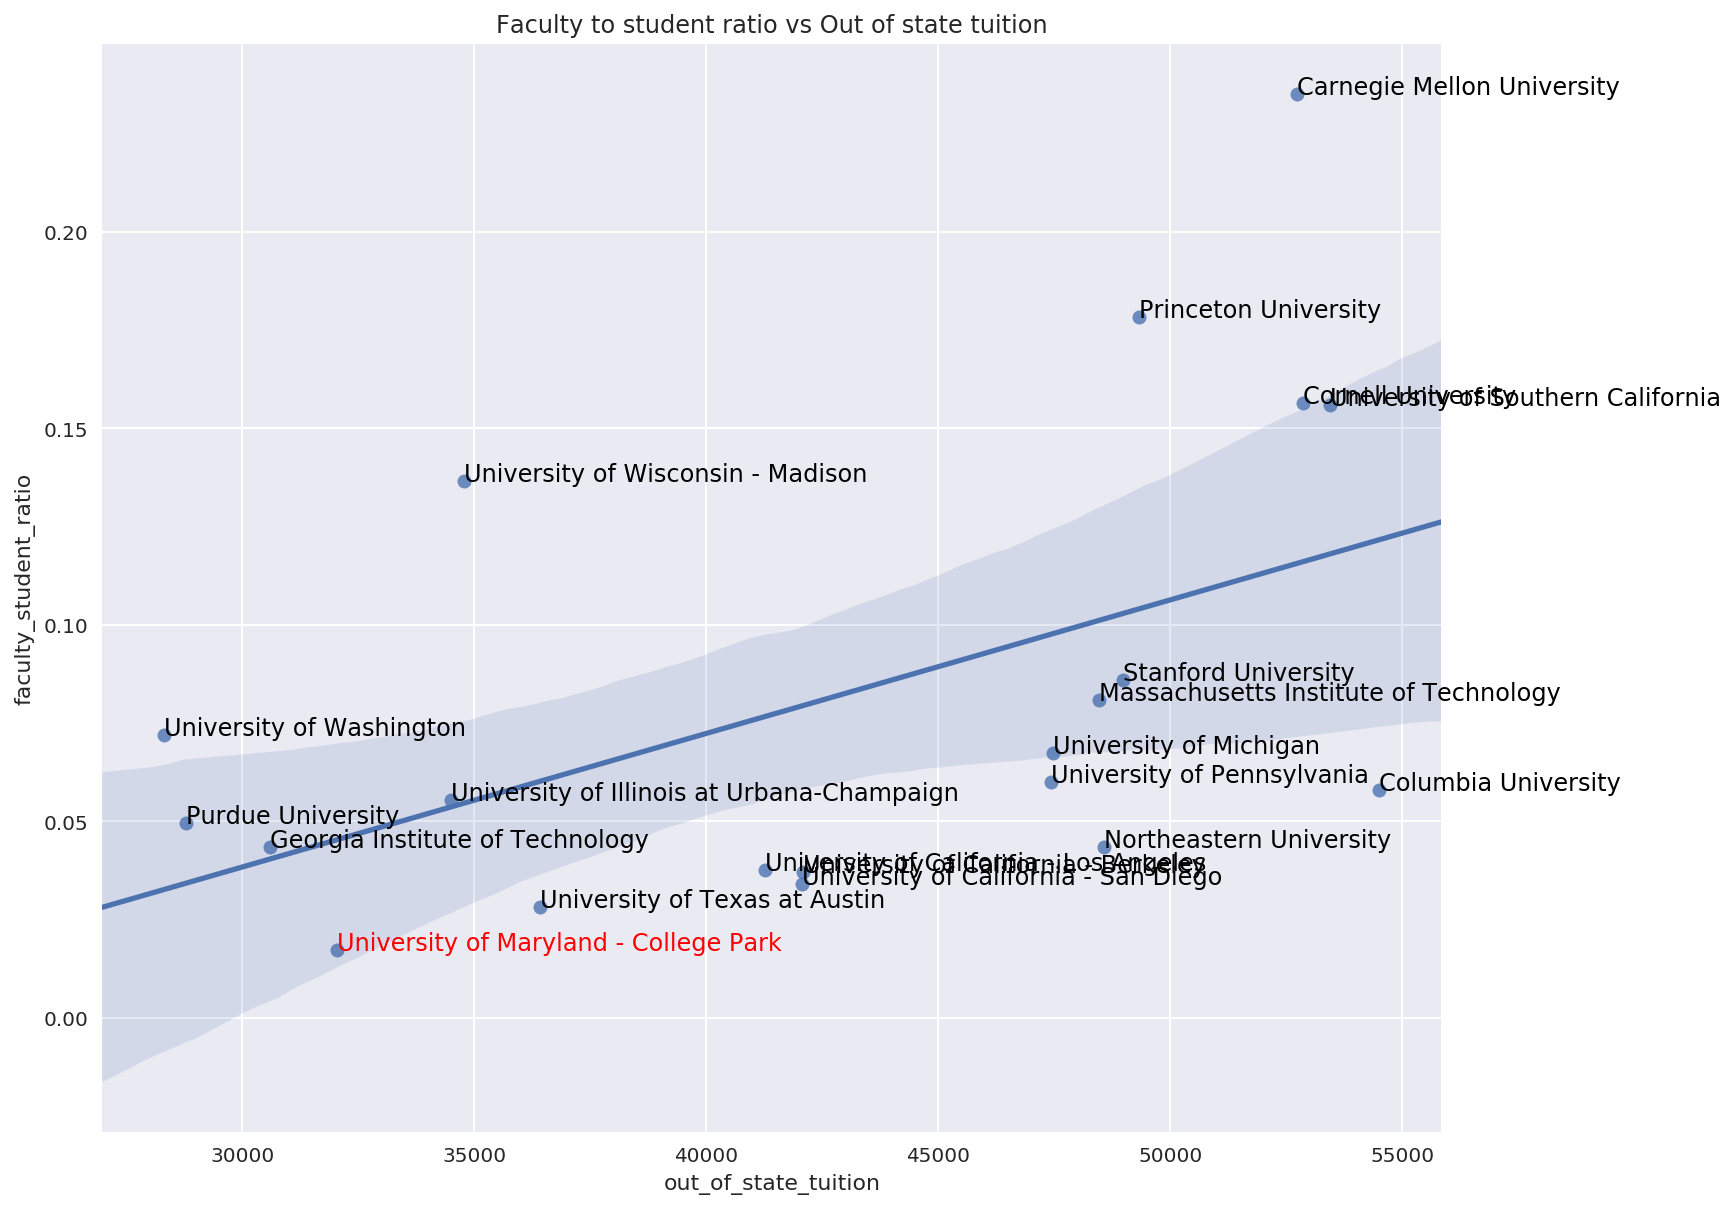

In [27]:
# calculating how much of a professor every student gets to themselves
top_20['faculty_student_ratio'] = top_20['faculty_count']/top_20['undergraduate_pop']
# plotting faculty-student ratio vs out of state tuition
regplot_top20(top_20, "out_of_state_tuition", "faculty_student_ratio",
              "Faculty to student ratio vs Out of state tuition")

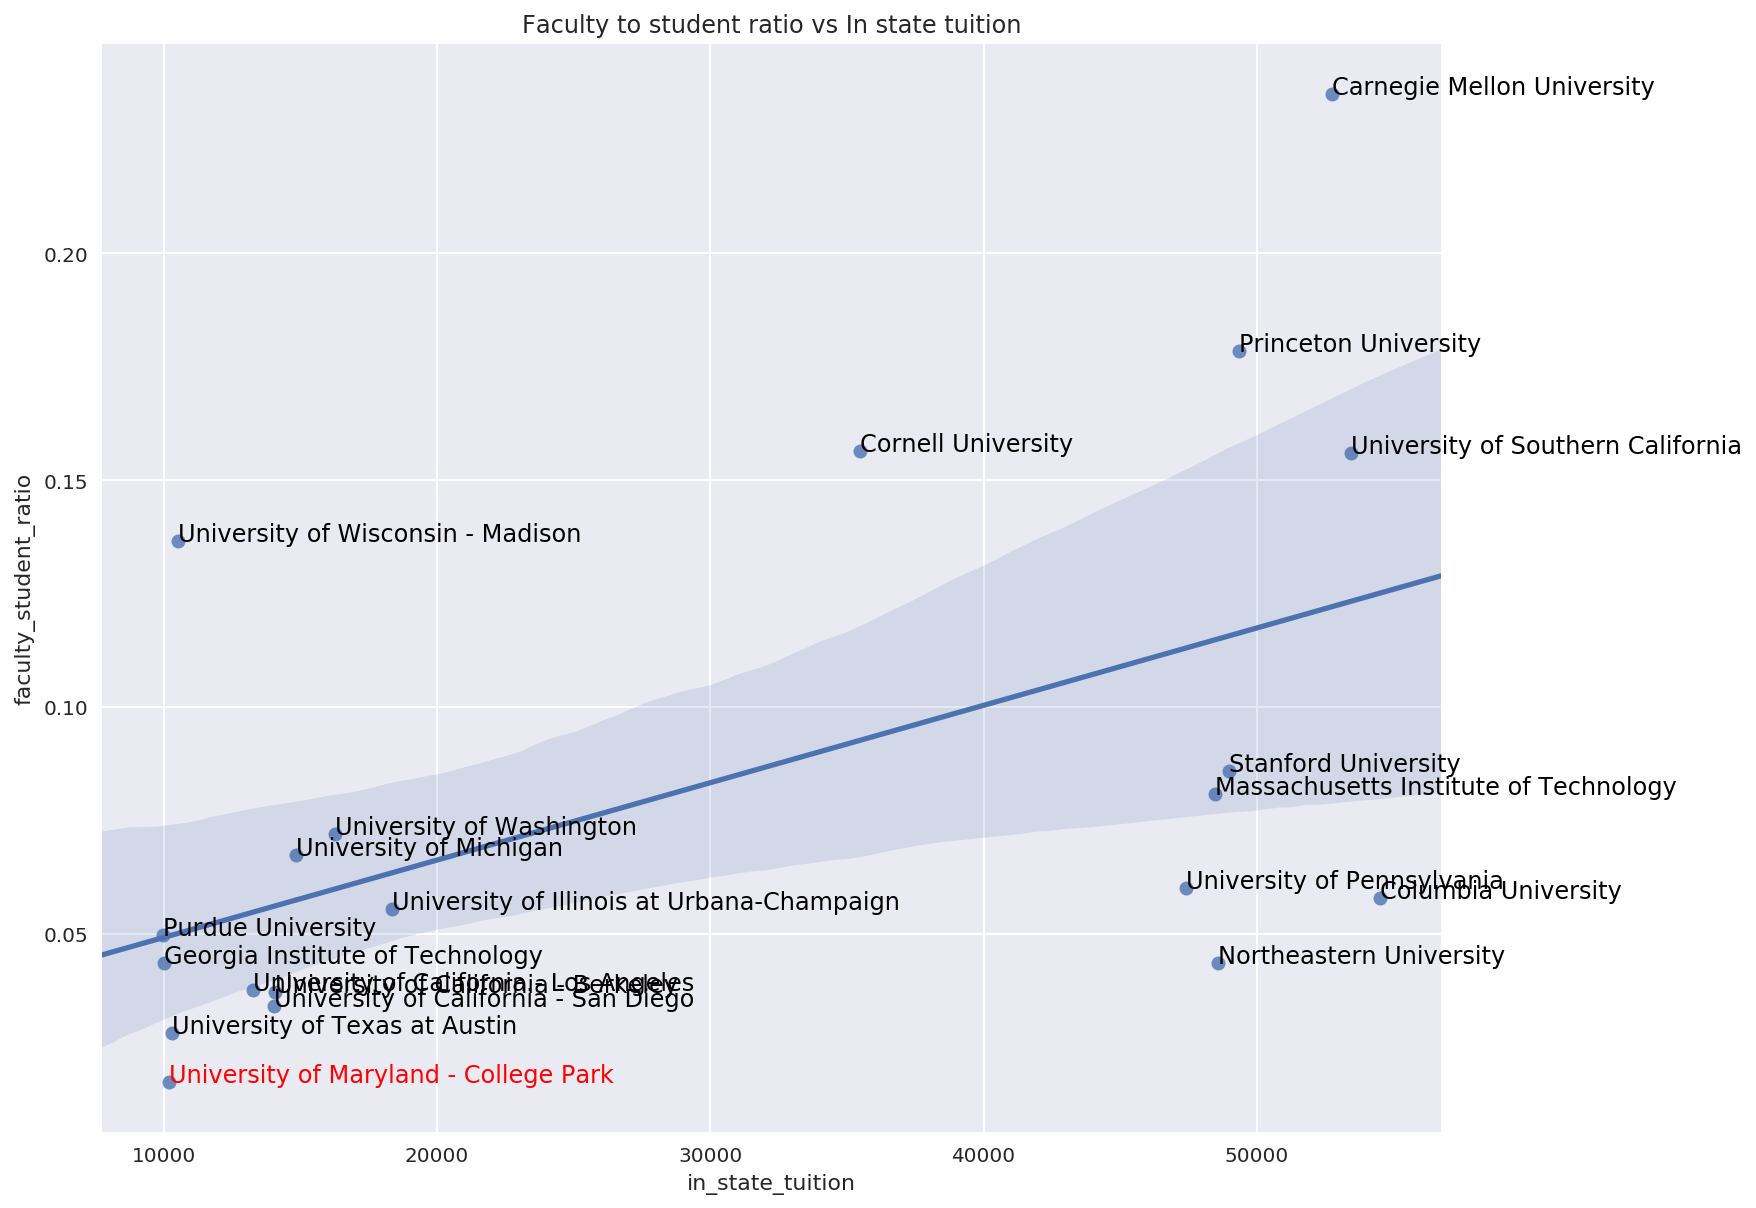

In [28]:
# plotting faculty count vs undergraduate population
regplot_top20(top_20, "in_state_tuition", "faculty_student_ratio",
              "Faculty to student ratio vs In state tuition")

It's looking better! Even though UMD's faculty to student ratio is the lowest, they are low cost too. Let's see if this holds up when we calculate bang for buck. We are going to distinguish public and private universities here, as private schools tend to have the same costs for both in-state and out of state.

In [29]:
# calculating out of state bang
top_20['bang_for_your_buck_out'] = (top_20['faculty_student_ratio']/top_20['out_of_state_tuition'])*1000
mean_out = top_20['bang_for_your_buck_out'].mean()
std_out = top_20['bang_for_your_buck_out'].std()
# normalizing our "bang for your buck" value
top_20['normalized_bang_for_your_buck_out'] = (top_20['bang_for_your_buck_out'] - mean_out)/std_out

# calculating in state bang
top_20['bang_for_your_buck_in'] = (top_20['faculty_student_ratio']/top_20['in_state_tuition'])*1000
mean_out = top_20['bang_for_your_buck_in'].mean()
std_out = top_20['bang_for_your_buck_in'].std()
# normalizing our "bang for your buck" value
top_20['normalized_bang_for_your_buck_in'] = (top_20['bang_for_your_buck_in'] - mean_out)/std_out

# sorting the schools by whether they are public or private
top_20_sorted_private_public = top_20.sort_values('public-private')

Text(0.5,1,'Bang for Your Buck (Out of State)')

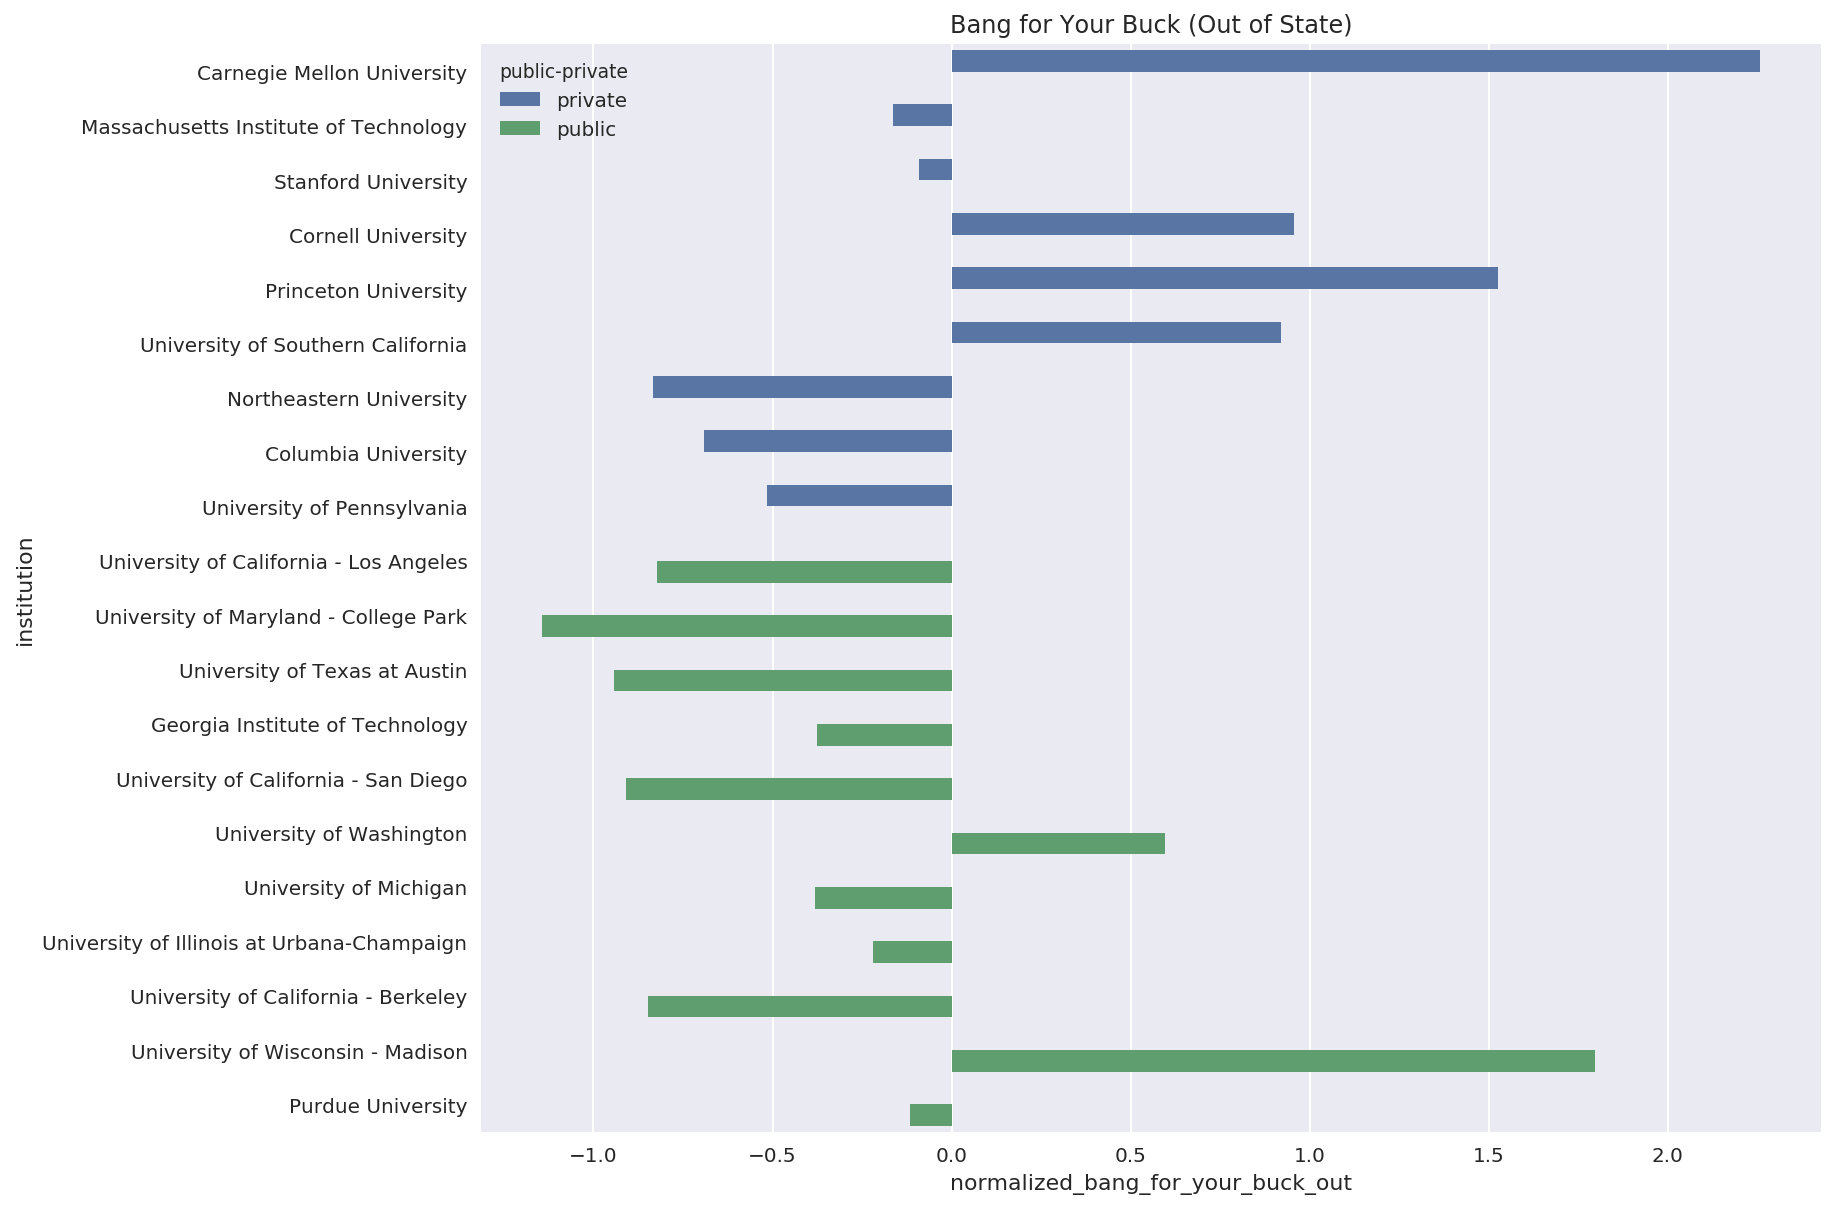

In [30]:
# Bang for your buck for out of state costs by institution
sns.barplot(y=top_20_sorted_private_public["institution"],
            x=top_20_sorted_private_public["normalized_bang_for_your_buck_out"],
            hue=top_20_sorted_private_public["public-private"])
plt.title("Bang for Your Buck (Out of State)")

Now, keeping private school tuitions constant, we're going to compare them to public universities' in state tuitions.

Text(0.5,1,'Bang for Your Buck (In State)')

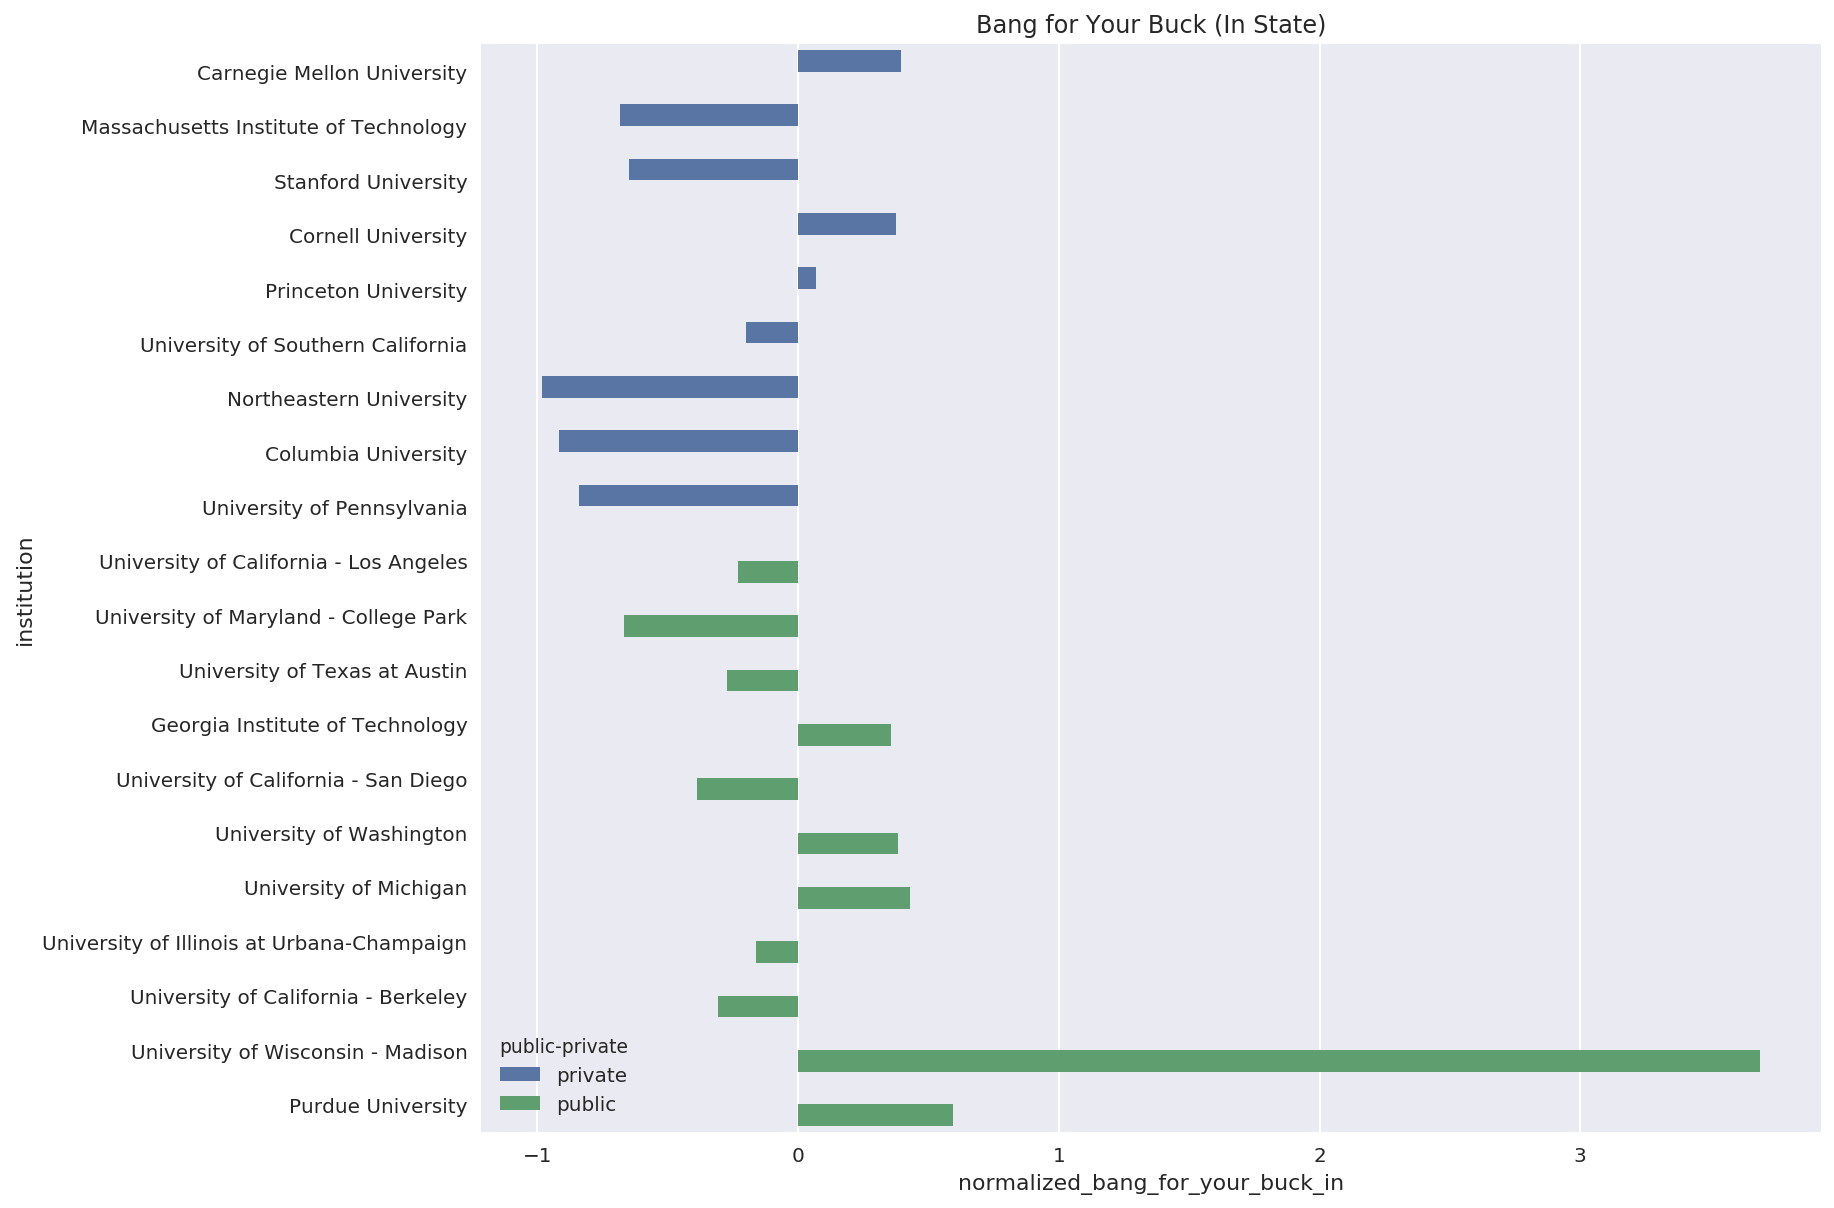

In [31]:
# Bang for your buck for in of state costs by institution
sns.barplot(y=top_20_sorted_private_public["institution"],
            x=top_20_sorted_private_public["normalized_bang_for_your_buck_in"],
            hue=top_20_sorted_private_public["public-private"])
plt.title("Bang for Your Buck (In State)")

As expected, the private schools fared worse in this comparison, with only Carnegie and Cornell having above average bang for buck. Also, way to go Wisconson.

On the other hand, it's not looking so great for UMD. It's the worst among all schools for out of state tuition. Even for in state tuition, UMD has the worst bang-for-buck among public universities. UMD is doing better than a few of the private schools, but not by much.

## How does this affect ranking?

We wanted to see how the factors we looked at affect rankings (since we know every school cares, and most people looking for them care), so we're going to plot US News rankings against our bang-for-your-buck score and student/faculty ratio. Our null hypothesis is that there is no correlation between these factors and ranking. The alternative is that there is a correlation which is significantly different from zero. 

We'll be using scipy's stats library to check how correlated the values are. If you want to learn more about hypothesis testing, p-values, and what they mean, check this link: https://cnx.org/contents/wAVi9myf@15/Linear-Regression-and-Correlat

Sadly, Northeastern didn't even make it into their ranking of global CS universities :( 

That means we have a NaN value in there, which can't be plotted. Although we set dropna to be true in our regplot function, it still bugged out when we tried to plot that row. So we'll just make a new table and drop Northeastern.

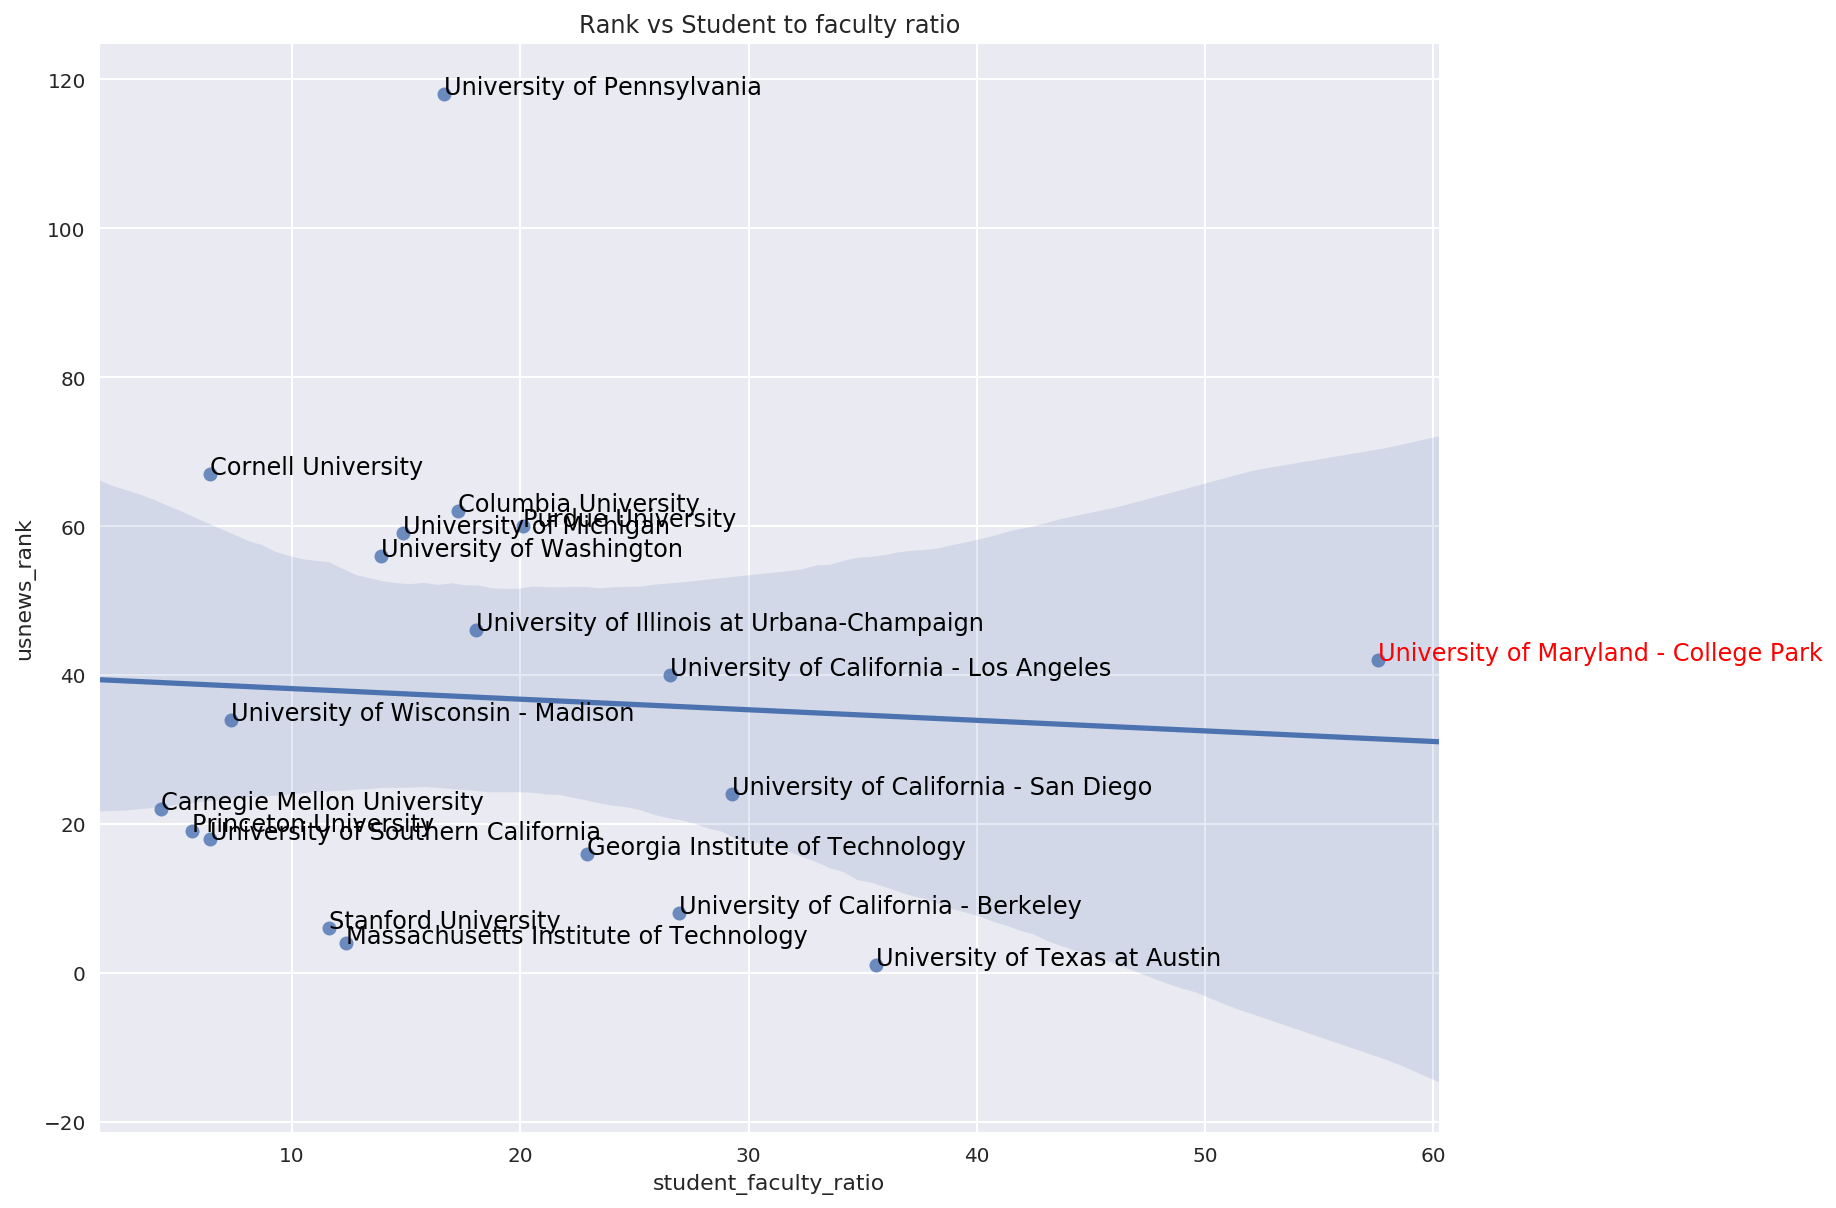

In [32]:
sorry_ne = top_20[["institution", "student_faculty_ratio", "usnews_rank", \
                   "normalized_bang_for_your_buck_out"]].copy()
sorry_ne.dropna(inplace=True)
sorry_ne.reset_index(inplace=True)
#plotting rank vs student to faculty ratio
regplot_top20(sorry_ne, "student_faculty_ratio", "usnews_rank",
              "Rank vs Student to faculty ratio")
# here, being in the bottom left corner is best. Then you're high rank and low student-faculty ratio

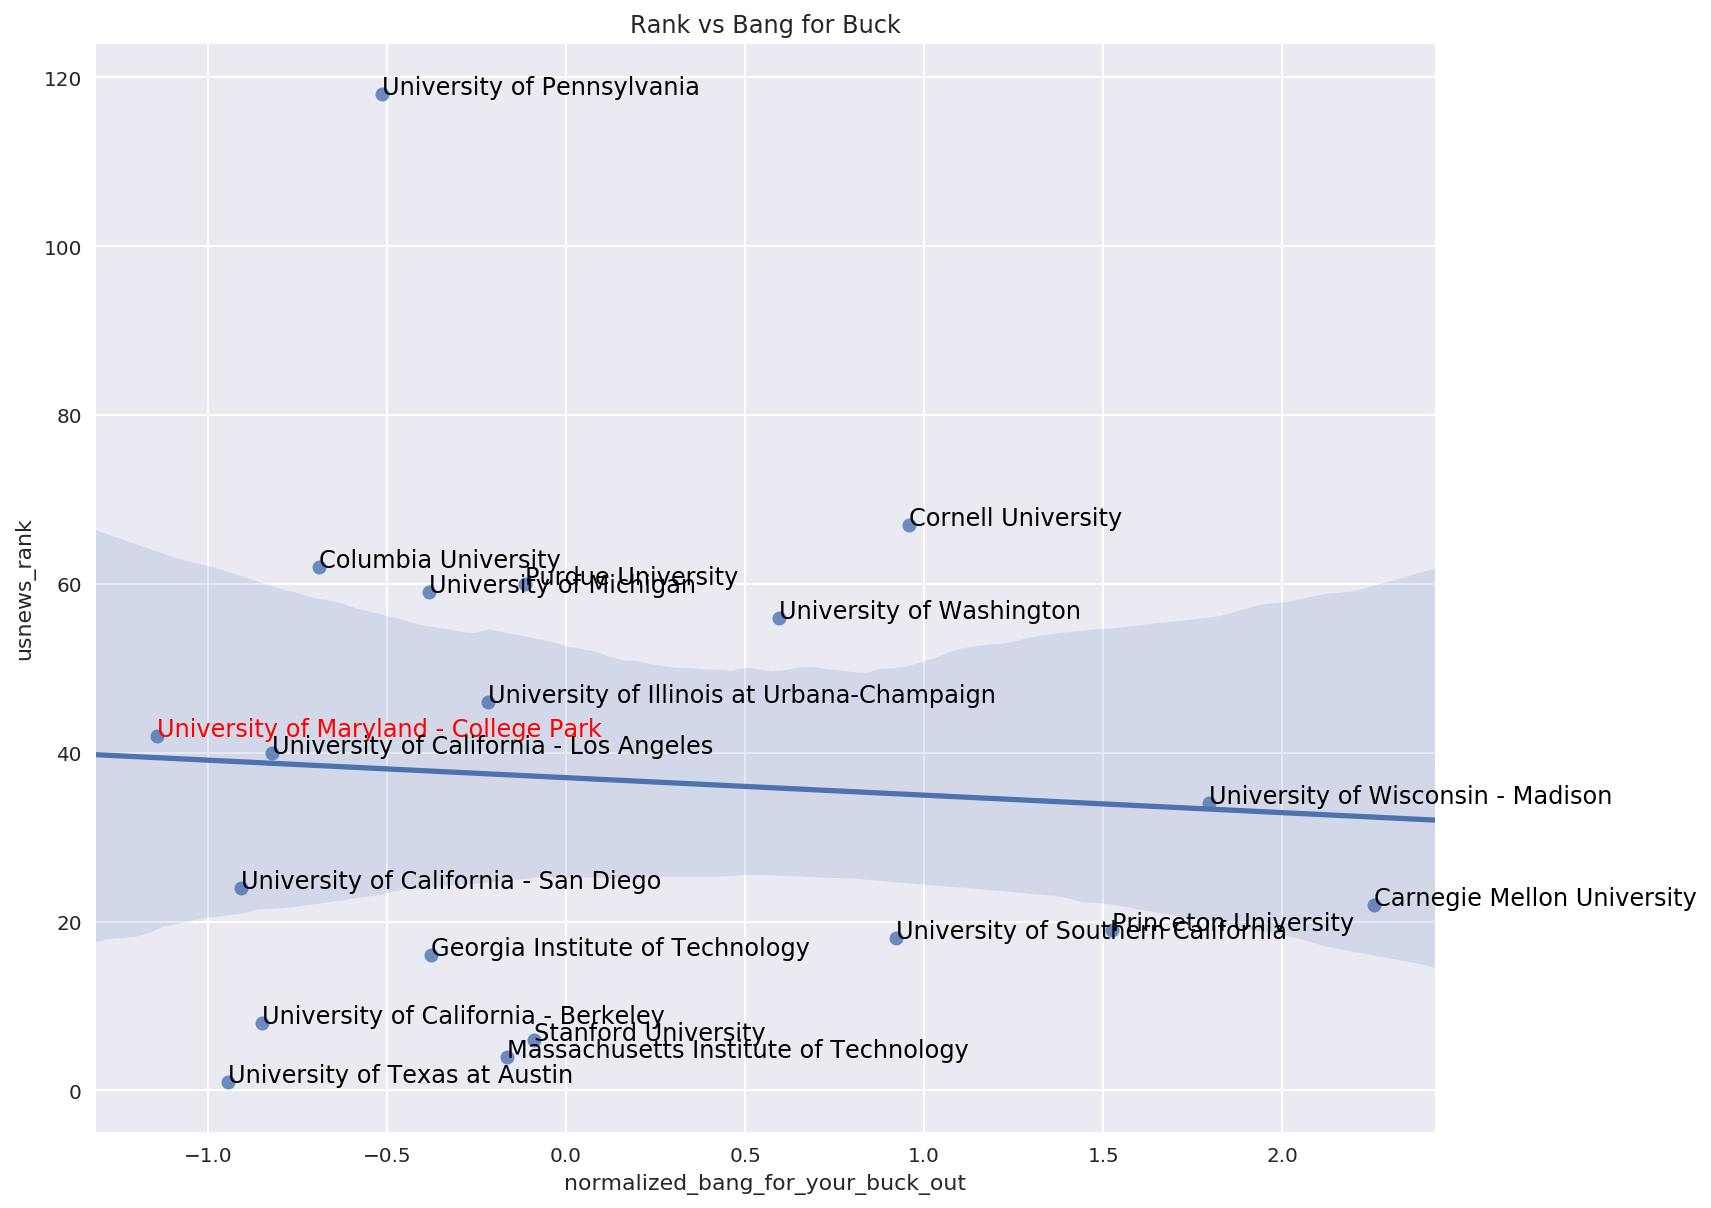

In [33]:
# plotting US News rank vs Bang for Buck
regplot_top20(sorry_ne, "normalized_bang_for_your_buck_out", "usnews_rank",
              "Rank vs Bang for Buck")
# here, being in the bottom right corner is best. You want a better ranking and a better bang for buck

Let's check that pearson's R and the corresponding p-value.

In [34]:
from scipy.stats import pearsonr

pearsons_r, p_value = pearsonr(sorry_ne['normalized_bang_for_your_buck_out'],sorry_ne['usnews_rank'])
print(pearsons_r)
print(p_value)

-0.0716066896768
0.770814051076


Our p-value of 0.72 indicates that the probability that we would see a correlation at least as extreme as this pearson's r given that the data is actually uncorrelated is quite high. As such, we can't reject the null hypothesis that there is no correlation between bang for your buck and usnews ranking. 

## UMD Computer Science Growth Rate

Student population data pulled from: https://public.tableau.com/shared/RJ346YP5Z?:display_count=no 

Tuition data pulled from: http://otcads.umd.edu/bfa/budgetinfo3.htm

We manually collected the data, as there were only 12 entries to acquire and we can't download it off tableau. Open data should really be a bigger priority, for everyone. If you want to learn a little more about the issue, you can read http://opendatahandbook.org/guide/en/what-is-open-data/

In [35]:
growth = pd.read_csv('UMD_populaton_intime.csv')
growth

,year,students,in_state_tuition,out_of_state_tuiton
0,Fall 2006,642,7821,20145
1,Fall 2007,692,6566,20005
2,Fall 2008,695,7969,22208
3,Fall 2009,796,8005,23076
4,Fall 2010,925,8053,23989
5,Fall 2011,1081,8416,24831
6,Fall 2012,1182,8655,26026
7,Fall 2013,1384,8908,27287
8,Fall 2014,1775,9161,28347
9,Fall 2015,2254,9427,29720


Let's start with some EDA by plotting the data

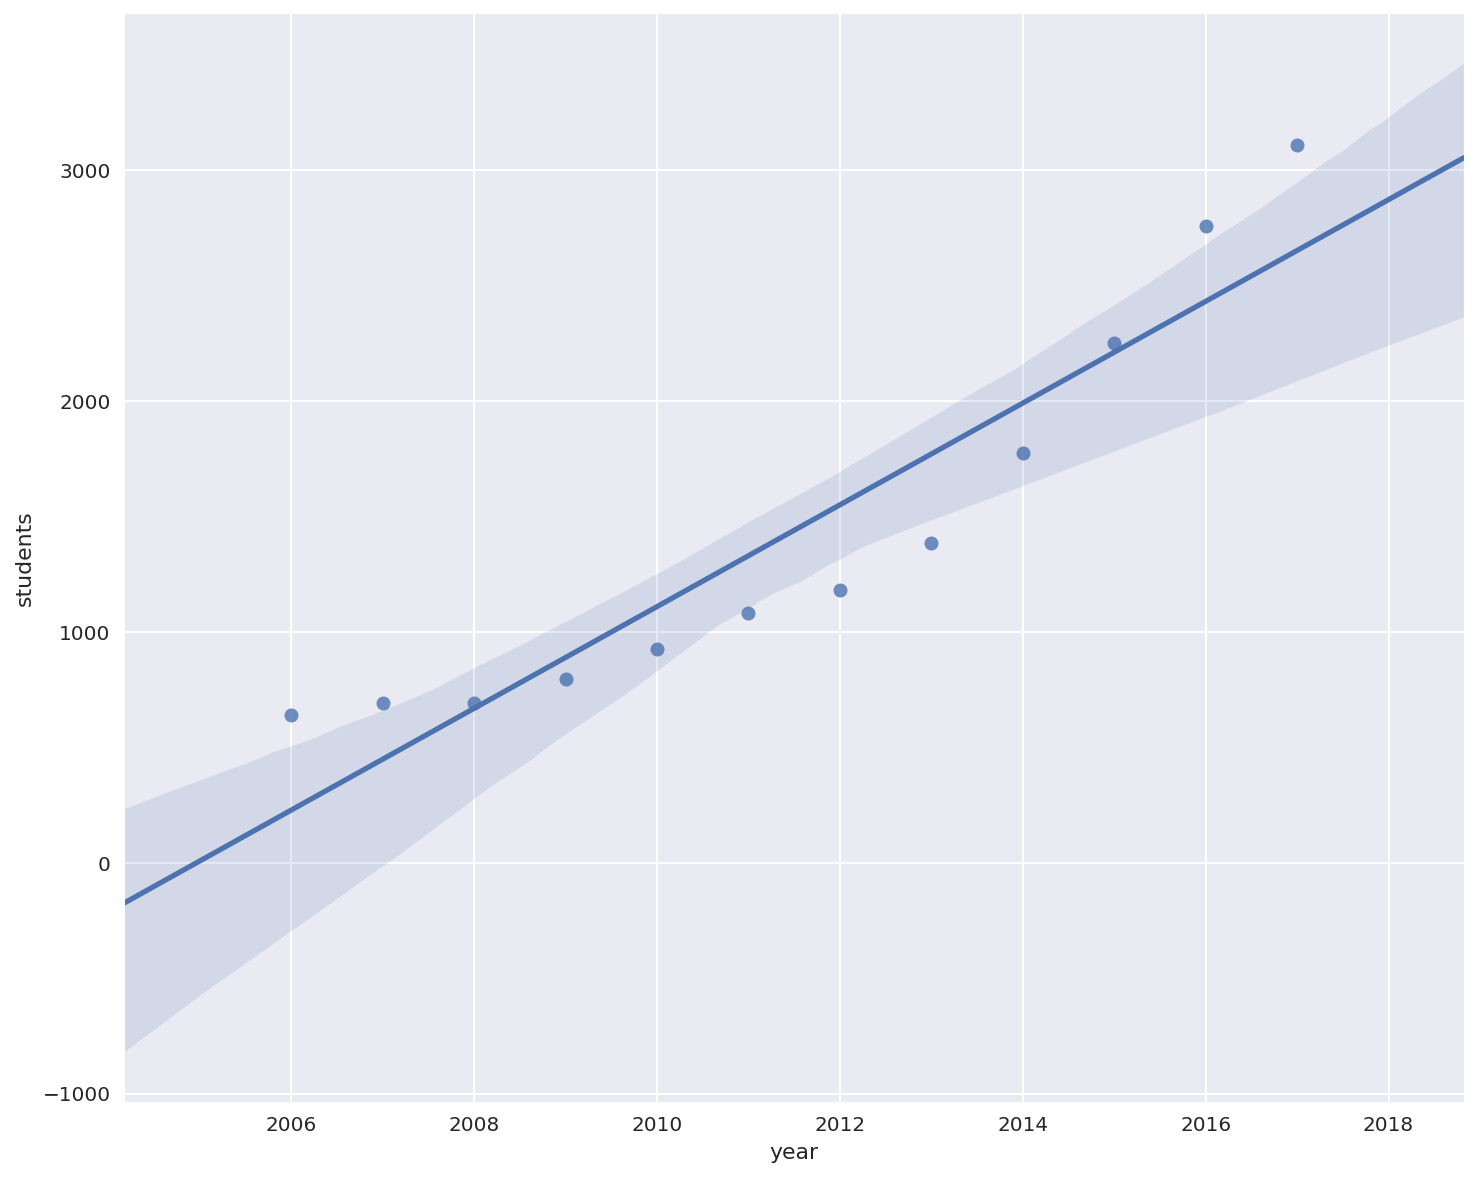

In [36]:
# removing the word "fall" from the year column so we can use it as a numerical value
growth['year'] = growth['year'].apply(lambda x: int(x[4:]))
sns.regplot(y=growth["students"], x=growth["year"])

It seems like we're growing pretty fast. Although the linear line seems to fit our data pretty well, it looks like our rate of growth is accelerating. We're going to try a polynomial fit and see how well that fits our data. To do this we can use scikit-learn's LinearRegression and PolynomialFeatures libraries. The latter library allows us to turn our single feature, years since 2006, into a polynomial feature (we're going to go with a second degree poly). This model may give an overestimation of our growth, but it should give us a general idea of where UMD is heading.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = growth[['year']]
# we're just normalizing the data a bit by counting years since 2006 instead of years since Christ was born
X = X-2006
y = growth['students']
print(X)
print(y)

    year
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
0      642
1      692
2      695
3      796
4      925
5     1081
6     1182
7     1384
8     1775
9     2254
10    2758
11    3109
Name: students, dtype: int64


In [38]:
poly = PolynomialFeatures(degree=2)
# here, we're changing the 1 feature that we have of x = years since 2006 into an array of 1+x+x^2
# so that we can fit a quadratic function to the data
poly_X = poly.fit_transform(X)
poly_X

array([[   1.,    0.,    0.],
       [   1.,    1.,    1.],
       [   1.,    2.,    4.],
       [   1.,    3.,    9.],
       [   1.,    4.,   16.],
       [   1.,    5.,   25.],
       [   1.,    6.,   36.],
       [   1.,    7.,   49.],
       [   1.,    8.,   64.],
       [   1.,    9.,   81.],
       [   1.,   10.,  100.],
       [   1.,   11.,  121.]])

In [39]:
poly_model = LinearRegression()
poly_model.fit(poly_X,y)
# let's try predicting the number of students in the year 2006+12 = 2018
poly_model.predict([[1, 12, 12**2]])

array([ 3673.52272727])

Oof, it's not looking so good for UMD, if this model is accurate. UMD already has an issue with student-faculty ratio, and it looks like it's expected to grow even larger. Let's see how accurate this model is by plotting its predictions for the years 2006 to 2021, as well as the actual data points we have.

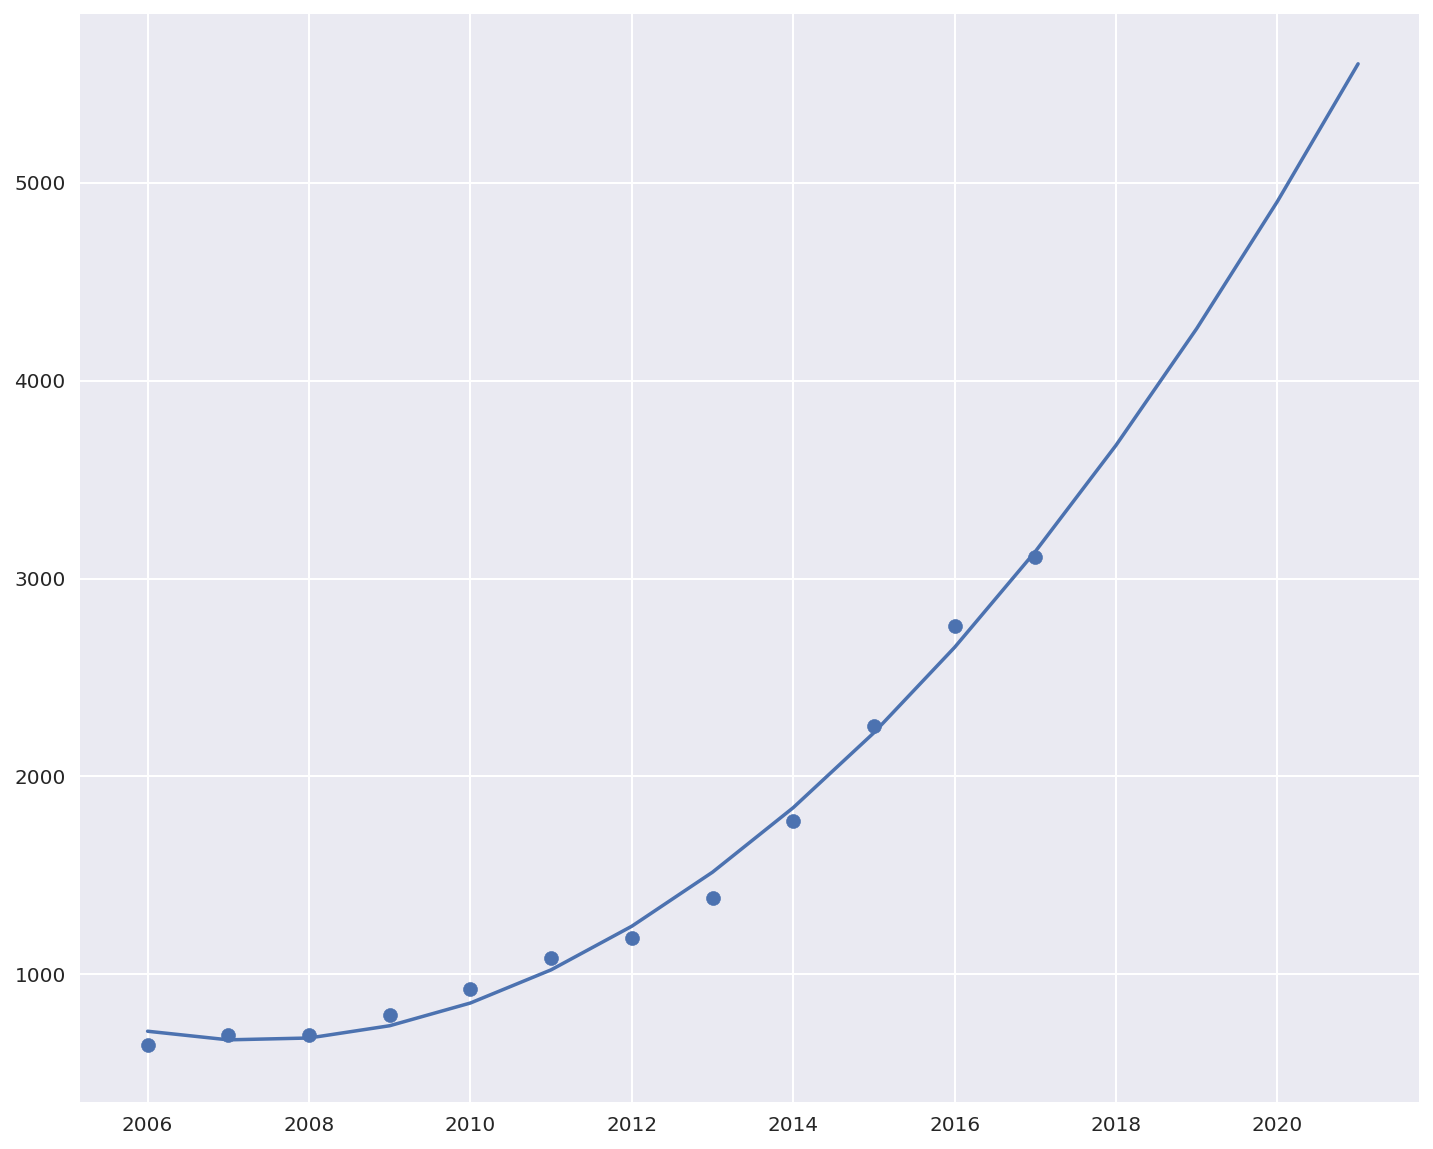

In [40]:
coefs = poly_model.coef_
years = np.linspace(0, 15, 16).reshape(-1, 1)
poly_years = poly.fit_transform(years)
years = years+2006
predictions = poly_model.predict(poly_years)

plt.plot(years, predictions)
plt.scatter(y=growth["students"], x=growth["year"])

It's not looking so hot for UMD. We're projected to keep growing, and it looks like we're going to grow pretty quickly too.

## What does UMD need to do to keep up?

We have learned from our analysis that UMD is above the average in terms of student-faculty ratio. Now that we have a model that we can use to predict UMD's growth rate, we can find out what it needs to do to keep up with the average student-faculty ratio of other top 20 schools. 

First let's calculate that average for the other schools.

In [41]:
# only grabbing rows where the institution isn't called College Park
top_20_no_umd = top_20[top_20["institution"] != "University of Maryland - College Park"].copy()
# calculating and printing the mean student to faculty ratio
mean_sf_ratio = top_20_no_umd["student_faculty_ratio"].mean()
umd_sf_ratio = top_20[top_20["institution"] == "University of Maryland - College Park"]["student_faculty_ratio"]

print("Mean student-faculty ratio for other schools: {}".format(mean_sf_ratio))
print("Student-faculty ratio for UMD: {}".format(umd_sf_ratio))

Mean student-faculty ratio for other schools: 16.792664280100997
Student-faculty ratio for UMD: 16    57.574074
Name: student_faculty_ratio, dtype: float64


Okay, so it looks like there are about 17 professors per student on average at other schools. Whereas UMD has about 57.5.

In [42]:
umd_faculty = top_20[top_20["institution"] == "University of Maryland - College Park"]["faculty_count"]
umd_students = top_20[top_20["institution"] == "University of Maryland - College Park"]["undergraduate_pop"]
# we want to find how many professors we'll need to hire, x, to meet the mean. 
# So we're solving the simple equation 16.95 = umd_students/(umd_faculty + x) for x
need_to_hire = (1/mean_sf_ratio)*(umd_students - mean_sf_ratio*umd_faculty)
need_to_hire

16    131.140365
dtype: float64

Ouch. I don't think that's feasible. How about we only compare to public schools and try again?

In [43]:
top_20_public = top_20_no_umd[top_20_no_umd["public-private"] == "public"]
mean_pub_ratio = top_20_public["student_faculty_ratio"].mean()
print("Mean student-faculty ratio for other public schools: {}".format(mean_pub_ratio))
need_to_hire = (1/mean_pub_ratio)*(umd_students - mean_pub_ratio*umd_faculty)
need_to_hire

Mean student-faculty ratio for other public schools: 21.552832688547813


16    90.25018
dtype: float64

A little more attainable. And that's how many professors are needed just to match up with the average right now. What if UMD grows even larger? I don't think UMD can possibly match up with the average anytime soon, but how about a goal? The mean is about 22 for public schools right now. Let's predict how many students UMD will have in 2020 and see how many professors UMD needs to reach a student-faculty ratio of 35 (what UT Austin currently has, the second highest overall student-faculty ratio of our top 20).

In [44]:
# 2020 is 14 years past 2006, so we'll use 14 as our x
umd_students_2020 = poly_model.predict([[1, 14, 14**2]])
# note that this is probably an overestimation. Hopefully growth will be reigned in somehow by 2020
# but based on current trends, if nothing changes, this looks to be a pretty accurate prediction
need_to_hire = float((1/35)*(umd_students - 35*umd_faculty))
need_to_hire_growth = float((1/35)*(umd_students_2020 - 35*umd_faculty))
print("How many professors should be hired if UMD doesn't grow at all until 2020: {}"
      .format(need_to_hire))
print("How many professors should be hired if UMD does grow as predicted in 2020: {}"
      .format(need_to_hire_growth))


How many professors should be hired if UMD doesn't grow at all until 2020: 34.82857142857143
How many professors should be hired if UMD does grow as predicted in 2020: 86.16120308263164


That is way more doable (If UMD CS does't grow at all)! UMD needs a NET GROWTH of 35 professors over the next 2 years (it's basically 2018) in order to have a student faculty ratio that is on par with our next closest "competitor" for highest student-faculty ratio (If UMD CS does't grow at all). This seems like a pretty reasonable goal to attain, and a reasonable way to get there (If UMD CS does't grow at all).

Let's be honest. UMD is probably going to grow. And if UMD wants to meet the goal of becoming a top 10 CS school by 2025, it needs to do much better than it's doing now. The department has to grow to meet the demands of the student body. The school clearly needs to hire more professors for the largest department on campus. 

Seeing these numbers, it's amazing that the professors here have been able to provide as good of an education as they have, considering how many more students each ones has to teach. Our upper level classes are becoming too large, and it's unfair to both the professors and students who deserve more intimate interactions with their student body and faculty.

All csv files used can be found at: https://github.com/krixly/krixly.github.io